In [1]:
import torch.nn.functional as F
from torch import nn
import torch.fft 
import matplotlib.pyplot as plt
from matplotlib.mlab import psd
import numpy as np
import scipy.stats
from scipy import special
import statistics
from torchviz import make_dot
import tikzplotlib
import numpy.fft as npft
import os
from scipy.signal import savgol_filter

# from tensorflow.keras.utils import to_categorical
from torch.optim import Adam as tAdam
from torch.utils import data
import matlab.engine
import scipy.io
from torch.cuda.amp import custom_bwd, custom_fwd

eng =  1 #matlab.engine.start_matlab()
device =  'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.cuda.set_device(device)
# device = torch.device("cpu")

print(torch.cuda.get_device_name())
print(eng)
  

class FD_CNN_MU_V2(nn.Module):
    def __init__(self,num_CN=[4,4],num_fc1=[512,256],submap=list(range(0,16)),U=1,K_act=256):
        super(FD_CNN_MU_V2, self).__init__()
        self.cn0 = nn.Conv2d(2*U, num_CN[0], 3, stride=1,padding=1)
        self.cn1 = nn.Conv2d(num_CN[0], num_CN[1], 3, stride=1,padding=1)
#         self.cn2 = nn.Conv2d(num_CN[0], num_CN[1], 3, stride=1,padding=1)
#         self.cn3 = nn.Conv2d(num_CN[0], num_CN[1], 3, stride=1,padding=1)
        self.fc1 = nn.Linear(num_fc1[0], num_fc1[1])
        self.submap = submap
        self.U = U
        self.K_act = K_act
        self.num_fc1 = num_fc1
    def forward(self, in_message):
        _in_message = torch.reshape(in_message.clone(), (-1,2,int(self.num_fc1[1]/2),self.U)) 
        _in_message_pow = torch.sqrt(2*torch.mean(_in_message**2))
        x = F.relu(self.cn0(in_message))
        x = self.cn1(x)
#         x_real = F.relu(self.cn2(x))
#         x_imag = F.relu(self.cn3(x))
#         x_real = torch.mean(x_real,dim=1).view(-1,self.K_act,self.U)
#         x_imag = torch.mean(x_imag,dim=1).view(-1,self.K_act,self.U)
#         x = torch.cat((x_real, x_imag),dim=2)
        for u in range(U):
            x_u = self.fc1(x[:,2*u:2*u+2,:,:].reshape(-1,self.num_fc1[0]))
            if u==0:
                x = x_u
            else:
                x = torch.cat((x,x_u),dim=2)
        x = x.view(-1,2,int(self.num_fc1[1]/2),self.U)
        x[:,:,self.submap,:] = x[:,:,self.submap,:] + _in_message # add residual connection
#         x = _in_message_pow*(x / torch.sqrt(2 * torch.mean(x**2)))
        return  x 

def cal_input_gain(snr,sigma,s,M,up_rate=1):
    Eb_now = torch.tensor(1.0/up_rate).to(device)/np.log2(M)
    Eb_expected = 10**(snr/10)*(2*sigma**2)
    gain = torch.sqrt(Eb_expected/Eb_now)
    return gain

def one_hot_generate(num, M):
    m = torch.randint(0,M,size=(num,))
    #b = np.unpackbits(m.numpy())
    m_one_hot = torch.nn.functional.one_hot(m, M).reshape(-1,M).float().to(device)
    return m.to(device), m_one_hot

def real_to_c(x):
    x_complex =  x[:,0:1] + 1j*x[:,1:]
    return x_complex

def c_to_real(x):
    x =  torch.hstack((x.real, x.imag))
    return x


def const_map(m, M):
    if M==2:
        symbols = torch.tensor([-1, 1])
    elif M==4:
        symbols = torch.tensor([-1-1j, -1+1j, +1-1j, +1+1j])
    elif M==8:
        symbols = torch.tensor([torch.exp(1j*2*torch.tensor(np.pi)/8*0), torch.exp(1j*2*torch.tensor(np.pi)/8*1),
                               torch.exp(1j*2*torch.tensor(np.pi)/8*7), torch.exp(1j*2*torch.tensor(np.pi)/8*6),
                               torch.exp(1j*2*torch.tensor(np.pi)/8*3), torch.exp(1j*2*torch.tensor(np.pi)/8*2),
                               torch.exp(1j*2*torch.tensor(np.pi)/8*4), torch.exp(1j*2*torch.tensor(np.pi)/8*5)])
    elif M==16:
        symbols = torch.tensor([-3-3j,-3-1j,-3+3j,-3+1j,
                                -1-3j,-1-1j,-1+3j,-1+1j, 
                                +3-3j,+3-1j,+3+3j,+3+1j,
                                +1-3j,+1-1j,+1+3j,+1+1j ])
    elif M ==64:
        symbols = torch.tensor([-7-7j,-7-5j,-7-1j,-7-3j,-7+7j,-7+5j,-7+1j,-7+3j, 
                                -5-7j,-5-5j,-5-1j,-5-3j,-5+7j,-5+5j,-5+1j,-5+3j,
                                -1-7j,-1-5j,-1-1j,-1-3j,-1+7j,-1+5j,-1+1j,-1+3j,
                                -3-7j,-3-5j,-3-1j,-3-3j,-3+7j,-3+5j,-3+1j,-3+3j,
                                +7-7j,+7-5j,+7-1j,+7-3j,+7+7j,+7+5j,+7+1j,+7+3j,
                                +5-7j,+5-5j,+5-1j,+5-3j,+5+7j,+5+5j,+5+1j,+5+3j,
                                +1-7j,+1-5j,+1-1j,+1-3j,+1+7j,+1+5j,+1+1j,+1+3j,
                                +3-7j,+3-5j,+3-1j,+3-3j,+3+7j,+3+5j,+3+1j,+3+3j ])
    elif M==256:
        symbols = torch.tensor([-15 + 15j,-15 + 13j,-15 + 9j,-15 + 11j,-15 + 1j,-15 + 3j,-15 + 7j,
                                -15 + 5j,-15 - 15j,-15 - 13j,-15 - 9j,-15 - 11j,-15 - 1j,-15 - 3j,
                                -15 - 7j,-15 - 5j,-13 + 15j,-13 + 13j,-13 + 9j,-13 + 11j,-13 + 1j,
                                -13 + 3j,-13 + 7j,-13 + 5j,-13 - 15j,-13 - 13j,-13 - 9j,-13 - 11j,
                                -13 - 1j,-13 - 3j,-13 - 7j,-13 - 5j,-9 + 15j,-9 + 13j,-9 + 9j,
                                -9 + 11j,-9 + 1j,-9 + 3j,-9 + 7j,-9 + 5j,-9 - 15j,-9 - 13j,-9 - 9j,
                                -9 - 11j,-9 - 1j,-9 - 3j,-9 - 7j,-9 - 5j,-11 + 15j,-11 + 13j,-11 + 9j,
                                -11 + 11j,-11 + 1j,-11 + 3j,-11 + 7j,-11 + 5j,-11 - 15j,-11 - 13j,
                                -11 - 9j,-11 - 11j,-11 - 1j,-11 - 3j,-11 - 7j,-11 - 5j,-1 + 15j,-1 + 13j,
                                -1 + 9j,-1 + 11j,-1 + 1j,-1 + 3j,-1 + 7j,-1 + 5j,-1 - 15j,-1 - 13j,
                                -1 - 9j,-1 - 11j,-1 - 1j,-1 - 3j,-1 - 7j,-1 - 5j,-3 + 15j,-3 + 13j,
                                -3 + 9j,-3 + 11j,-3 + 1j,-3 + 3j,-3 + 7j,-3 + 5j,-3 - 15j,-3 - 13j,-3 - 9j,
                                -3 - 11j,-3 - 1j,-3 - 3j,-3 - 7j,-3 - 5j,-7 + 15j,-7 + 13j,-7 + 9j,-7 + 11j,
                                -7 + 1j,-7 + 3j,-7 + 7j,-7 + 5j,-7 - 15j,-7 - 13j,-7 - 9j,-7 - 11j,-7 - 1j,
                                -7 - 3j,-7 - 7j,-7 - 5j,-5 + 15j,-5 + 13j,-5 + 9j,-5 + 11j,-5 + 1j,-5 + 3j,
                                -5 + 7j,-5 + 5j,-5 - 15j,-5 - 13j,-5 - 9j,-5 - 11j,-5 - 1j,-5 - 3j,-5 - 7j,
                                -5 - 5j,15 + 15j,15 + 13j,15 + 9j,15 + 11j,15 + 1j,15 + 3j,15 + 7j,15 + 5j,
                                15 - 15j,15 - 13j,15 - 9j,15 - 11j,15 - 1j,15 - 3j,15 - 7j,15 - 5j,13 + 15j,
                                13 + 13j,13 + 9j,13 + 11j,13 + 1j,13 + 3j,13 + 7j,13 + 5j,13 - 15j,13 - 13j,
                                13 - 9j,13 - 11j,13 - 1j,13 - 3j,13 - 7j,13 - 5j,9 + 15j,9 + 13j,9 + 9j,
                                9 + 11j,9 + 1j,9 + 3j,9 + 7j,9 + 5j,9 - 15j,9 - 13j,9 - 9j,9 - 11j,9 - 1j,9 - 3j,
                                9 - 7j,9 - 5j,11 + 15j,11 + 13j,11 + 9j,11 + 11j,11 + 1j,11 + 3j,11 + 7j,
                                11 + 5j,11 - 15j,11 - 13j,11 - 9j,11 - 11j,11 - 1j,11 - 3j,11 - 7j,11 - 5j,
                                1 + 15j,1 + 13j,1 + 9j,1 + 11j,1 + 1j,1 + 3j,1 + 7j,1 + 5j,1 - 15j,1 - 13j,1 - 9j,
                                1 - 11j,1 - 1j,1 - 3j,1 - 7j,1 - 5j,3 + 15j,3 + 13j,3 + 9j,3 + 11j,3 + 1j,3 + 3j,
                                3 + 7j,3 + 5j,3 - 15j,3 - 13j,3 - 9j,3 - 11j,3 - 1j,3 - 3j,3 - 7j,3 - 5j,7 + 15j,
                                7 + 13j,7 + 9j,7 + 11j,7 + 1j,7 + 3j,7 + 7j,7 + 5j,7 - 15j,7 - 13j,7 - 9j,7 - 11j,
                                7 - 1j,7 - 3j,7 - 7j,7 - 5j,5 + 15j,5 + 13j,5 + 9j,5 + 11j,5 + 1j,5 + 3j,5 + 7j,
                                5 + 5j,5 - 15j,5 - 13j,5 - 9j,5 - 11j,5 - 1j,5 - 3j,5 - 7j,5 - 5j ])
    symbols = symbols/np.sqrt((M-1)*4/6)
    return symbols[m], symbols


    
def const_demap(rx_symbs,const,M,custom_decod=False):
    '''
    Eucledian distance detector
    ''' 
    rx_symbs_matrix = rx_symbs.reshape(-1,1).repeat_interleave(M,1)
    const_matrix = const.reshape(1,-1).repeat_interleave(rx_symbs.shape[0],0)
    m_hat = torch.argmin(torch.abs(rx_symbs_matrix-const_matrix)**2,axis=1)
    return m_hat.to(device)


def PA(x, pa_model='tanh',tanh_lim=1,gain_factor=1,sat=24.02,K=[3,0,0],M=[3,0,0],eng=eng,b=0):
    
    if pa_model is 'ideal':
        gmp = np.load('gmp_750.npz')
        gmp_out_max=torch.tensor(gmp['out_max'],dtype=torch.complex64).to(device)
        noise_var = torch.tensor(0.0028).to(device)
        noise = torch.sqrt(noise_var/2) * torch.randn(x.shape).to(device)
        x_abs = torch.sqrt(torch.sum(x**2,-1)).view(-1,1)
        x_abs = gain_factor*x_abs
        x_abs = dclamp(x_abs, 0,float(gmp['out_max']))

        with torch.no_grad(): 
            x_angle=torch.angle(real_to_c(x))
        pa_out = x_abs*torch.hstack((torch.cos(x_angle),torch.sin(x_angle))) + noise
        return pa_out
    
    if pa_model is 'gmp':
        # GMP parameters: 
        gmp_name = os.path.join('Buffer_files', 'gmp_memory_K7M5'+str(b)+'.npz')  # gmp_memory_K7M5   or  gmp_memoryless_
        
        gmp = np.load(gmp_name)
        weblab_gain = np.sqrt(10**(51.0/10))

        gmp_coe=torch.tensor(gmp['coe'],dtype=torch.complex64).to(device)
        gmp_in_max=50#torch.tensor(gmp['in_max'],dtype=torch.complex64).to(device)
        gmp_out_max=torch.tensor(gmp['out_max'],dtype=torch.complex64).to(device)        
        x = x*weblab_gain
                    
        with torch.no_grad():
            x_norm = torch.sqrt(torch.sum(x**2,-1).view(-1,1))
            x_norm[x_norm==0]=1
        x_angle = x/x_norm
        _idx = torch.sqrt(x[:,0]**2+x[:,1]**2)>gmp_in_max
        x[_idx,:] = gmp_in_max*x_angle[_idx,:]
        
        pa_in_matrix_real,pa_in_matrix_imag = MP_real_valued(x, K = K, M=M, N=[0,0])
        gmp_coe_real = gmp_coe.real
        gmp_coe_imag = gmp_coe.imag
#         print(gmp_coe)
        
        y_real = (pa_in_matrix_real@gmp_coe_real - pa_in_matrix_imag@gmp_coe_imag)
        y_imag = (pa_in_matrix_imag@gmp_coe_real + pa_in_matrix_real@gmp_coe_imag)
        y = torch.hstack((y_real,y_imag))

        with torch.no_grad():
            y_norm = torch.sqrt(torch.sum(y**2,-1).view(-1,1))
            y_norm[y_norm==0]=1
        y_angle = y/y_norm

        _idx = torch.sqrt(y[:,0]**2+y[:,1]**2)>torch.abs(gmp_out_max)
        y[_idx,:] = torch.abs(gmp_out_max)*y_angle[_idx,:]
        return   y     
        
def MP_real_valued(x, K=None, M=None, N=None):
    """
    Build the memory polynomial model matrix, form the matrix X in the equation: Y = X*w.
    Details can be found in the paper "A Generalized Memory Polynomial Model for Digital Predistortion of RF Power Ampliﬁers"
    :param x: input signal
    :return: x_matrix, the formed input matrix
    """
#     print(x.shape)
    # First, form the MP envelope of GMP, number of parameters: K[0]*M[0]
    if M[0] > 0:
        x_memory = torch.vstack((torch.zeros((M[0],2)).to(device), x))
    else:
        x_memory = x
    for k in range(0, K[0]):
        for m in range(0, M[0]+1):
            if m == 0:
                x_array_real = torch.sqrt(x_memory[M[0]:, 0:1]**2+x_memory[M[0]:, 1:]**2) ** k * x_memory[M[0]:, 0:1]
                x_array_imag = torch.sqrt(x_memory[M[0]:, 0:1]**2+x_memory[M[0]:, 1:]**2) ** k * x_memory[M[0]:, 1:]
            else:
                x_array_real = torch.hstack((x_array_real, torch.sqrt(x_memory[M[0] - m: -m, 0:1]**2+
                                                                 x_memory[M[0] - m: -m, 1:]**2) ** k * x_memory[M[0] - m: -m, 0:1]))
                x_array_imag = torch.hstack((x_array_imag, torch.sqrt(x_memory[M[0] - m: -m, 0:1]**2+
                                                 x_memory[M[0] - m: -m, 1:]**2) ** k * x_memory[M[0] - m: -m, 1:]))
        if k == 0:
            x_matrix_real = x_array_real#.view(-1,1)
            x_matrix_imag = x_array_imag#.view(-1,1)
#             print(x_matrix_real.shape)
        else:
            x_matrix_real = torch.hstack((x_matrix_real, x_array_real))
            x_matrix_imag = torch.hstack((x_matrix_imag, x_array_imag))
#             print(x_matrix_real.shape)

    return x_matrix_real,x_matrix_imag

def memory_polynomial_model(x, K=None, M=None, N=None):
    """
    Build the memory polynomial model matrix, form the matrix X in the equation: Y = X*w.
    Details can be found in the paper "A Generalized Memory Polynomial Model for Digital Predistortion of RF Power Ampliﬁers"
    :param x: input signal
    :return: x_matrix, the formed input matrix
    """

    x_len = x.shape[0]
    # First, form the MP envelope of GMP, number of parameters: K[0]*M[0]
    if M[0] > 0:
        x_memory = torch.vstack((torch.zeros((M[0],1)).to(device), x))
    else:
        x_memory = x
    for k in range(0, K[0]):
        for m in range(0, M[0]+1):
            if m == 0:
                x_array = torch.abs(x_memory[M[0]:, :]) ** k * x_memory[M[0]:, :]
            else:
                x_array = torch.hstack((x_array, torch.abs(x_memory[M[0] - m: -m, :]) ** k * x_memory[M[0] - m: -m, :]))
        if k == 0:
            x_matrix = x_array
#                 print(x_matrix.shape)
        else:
            x_matrix = torch.hstack((x_matrix, x_array))
            
    # Then, form the lagging envelope of GMP, number of parameters: K[1]*M[1]*L[0]
    if N[0] > 0:
        x_memory = torch.vstack((torch.zeros((M[1]+N[0],1)).to(device), x))
        for k in range(1, K[1]+1):
            for m in range(0, M[1]+1):
                for n in range(1, N[0]+1):
                    idx = M[1] + N[0] - n - m
                    if n == 1:
#                             print(x_memory[idx: idx+x_len, :].shape)
#                             print(x_memory[idx+n: idx+n+x_len, :].shape)
                        x_array_cross = torch.abs(x_memory[idx: idx+x_len, :]) ** k * x_memory[idx+n: idx+n+x_len, :]
                    else:
                        x_array_cross = torch.hstack((x_array_cross, torch.abs(x_memory[idx: idx+x_len, :]) ** k *
                                                   x_memory[idx+n: idx+n+x_len, :]))
                if m == 0:
                    x_array = x_array_cross
                else:
                    x_array = torch.hstack((x_array, x_array_cross))
            x_matrix = torch.hstack((x_matrix, x_array))

    # Finally, form the leading envelope of GMP, number of parameters: K[2]*M[2]*L[1]
    if N[1] > 0:
        x_memory = torch.vstack((torch.zeros((M[2],1)).to(device), x))
        x_memory = torch.vstack((x_memory, torch.zeros((N[1]+1,1)).to(device)))
        for k in range(1, K[2]+1):
            for m in range(0, M[2]+1):
                for n in range(1, N[1]+1):
                    idx = M[2] + n - m
                    if n == 1:
                        x_array_cross = torch.abs(x_memory[idx: idx+x_len, :]) ** k * x_memory[idx-n: idx-n+x_len, :]
                    else:
                        x_array_cross = torch.hstack((x_array_cross, torch.abs(x_memory[idx: idx+x_len, :]) ** k *
                                                   x_memory[idx-n: idx-n+x_len, :]))
                if m == 0:
                    x_array = x_array_cross
                else:
                    x_array = torch.hstack((x_array, x_array_cross))
            x_matrix = torch.hstack((x_matrix, x_array))
    return x_matrix

def Beam_domain_MP_model(x1,x2,K=None, M=None, N=None,flag_cross_beam3=False):
    """
    Beam domain MP model with the basis function such as x1*|x2|^2, x2|x1|^2, etc
    """
    if M[0] > 0:
        x1_memory = torch.vstack((torch.zeros((M[0],1)).to(device), x1))
        x2_memory = torch.vstack((torch.zeros((M[0],1)).to(device), x2))

    else:
        x1_memory = x1
        x2_memory = x2
    if not flag_cross_beam3:
        for k in range(0, K[0]):
            for m in range(0, M[0]+1):
                if m == 0:
                    # Beams in the direction of x1
                    x_array = torch.abs(x2_memory[M[0]:, :]) ** k * x1_memory[M[0]:, :]
                else:
                    x_array = torch.hstack((x_array, torch.abs(x2_memory[M[0] - m: -m, :]) ** k \
                                                * x1_memory[M[0] - m: -m, :]))
            if k == 0:
                x_matrix = x_array
            else:
                x_matrix = torch.hstack((x_matrix, x_array))
    elif flag_cross_beam3:
        for k in range(2, K[0]):
            for m in range(0, M[0]+1):
                if m == 0:
                    # Beams in the direction of 2*x1-x2
                    x_array = torch.abs(x2_memory[M[0]:, :]) ** (k-2) * x1_memory[M[0]:, :] \
                    *x1_memory[M[0]:, :]*torch.conj(x2_memory[M[0]:, :])
#                     print(x_array.shape)
                else:
#                     print(torch.abs(x2_memory[M[0] - m: -m, :]))
                    # Beams in the direction of 2*x1-x2
                    x_array = torch.hstack((x_array, torch.abs(x2_memory[M[0] - m: -m, :]) ** (k-2)\
                               *x1_memory[M[0] - m: -m, :]*x1_memory[M[0] - m: -m, :]\
                               *torch.conj(x2_memory[M[0] - m: -m, :])))
#                     print(x_array.shape)
            if k == 2:
                x_matrix = x_array
            else:
                x_matrix = torch.hstack((x_matrix, x_array))
    return x_matrix
    



def SER(m_pred_oh, m_test, one_hot=True):
    if one_hot:
        m_pred = torch.argmax(m_pred_oh, dim=1)
    else:
        m_pred = m_pred_oh
#     m_pred[(m_pred==0)+(m_pred==4)+(m_pred==32)+(m_pred==36)]=0
#     m_test[(m_test==0)+(m_test==4)+(m_test==32)+(m_test==36)]=0
    num_corrct =  torch.sum(torch.eq(m_pred, m_test))
    ser = 1-(num_corrct/m_test.shape[0]).to('cpu').detach().numpy()
    return ser


def stack_memory_multi_dim(x,M,dim):
    for i in range(M+1):
        if i ==0:
            x_0 = x
        else:
            x_mem = torch.roll(x,i)
            x_0 = torch.cat((x_0,x_mem),dim=dim)
    return x_0


from torch.cuda.amp import custom_bwd, custom_fwd


class DifferentiableClamp(torch.autograd.Function):
    """
    In the forward pass this operation behaves like torch.clamp.
    But in the backward pass its gradient is 1 everywhere, as if instead of clamp one had used the identity function.
    """

    @staticmethod
    @custom_fwd
    def forward(ctx, input, min, max):
        return input.clamp(min=min, max=max)

    @staticmethod
    @custom_bwd
    def backward(ctx, grad_output):
        return grad_output.clone(), None, None


def dclamp(input, min=0, max=0):
    """
    Like torch.clamp, but with a constant 1-gradient.
    :param input: The input that is to be clamped.
    :param min: The minimum value of the output.
    :param max: The maximum value of the output.
    """
    return DifferentiableClamp.apply(input, min, max)

def zero_forcing(s,Hf,B,U,num_precod,num_OFDMs,return_P_only_flag=False):
    xf = torch.zeros(B,num_OFDMs,num_precod,dtype=torch.complex64)
    Pf = torch.zeros(B,U,num_precod,dtype=torch.complex64)
    beta = 0
    Hf = Hf.to('cpu')
    for i in range(0,num_precod):
        with torch.no_grad():
            # ZF
            Pf[:,:,i] = Hf[:,:,i].T.conj()@(torch.inverse(Hf[:,:,i]@Hf[:,:,i].T.conj()))
            beta = beta + np.trace(torch.inverse(Hf[:,:,i]@Hf[:,:,i].T.conj()).to('cpu'))/num_precod
            # MRT
#             Pf[:,:,i] = Hf[:,:,i].T.conj()
#             beta = beta +  np.trace((Hf[:,:,i]@Hf[:,:,i].T.conj()).to('cpu'))/num_precod

            #beta = np.sqrt(U/np.trace((Pf[:,:,i].T.conj()@Pf[:,:,i]).to('cpu')))
            #Pf[:,:,i] = Pf[:,:,i]*beta
        #xf[:,:,i] = Pf[:,:,i]@s[:,:,i]
        #xf_temp_real = Pf[:,:,i].real@s[:,:,i].real - Pf[:,:,i].imag@s[:,:,i].imag
        #xf_temp_imag = Pf[:,:,i].real@s[:,:,i].imag + Pf[:,:,i].imag@s[:,:,i].real
        #xf[:,:,i] = xf_temp_real.type(torch.complex64)+1j*xf_temp_imag.type(torch.complex64)
        #beta = torch.sqrt(torch.abs(Pf[:,:,i]))
    if return_P_only_flag:
        return Pf.to(device), np.sqrt(beta)
    s = s.to('cpu')
    for i in range(0,num_precod):
        xf[:,:,i] = complex_matrix_multi(Pf[:,:,i], s[:,:,i])
        #xf[:,:,i] = s[:,:,i]
    beta = np.sqrt(beta)
    xf = xf/beta
    Pf = Pf/beta
    return xf.to(device), Pf.to(device), beta

def complex_matrix_multi(x,y):
    '''
       Implement complexed valued matrix multiplication with real matrix multiplication for differential reason
   
    '''
    z_real = x.real@y.real - x.imag@y.imag
    z_imag = x.real@y.imag + x.imag@y.real
    return z_real.type(torch.complex64)+1j*z_imag.type(torch.complex64)

def crelu(input: torch.Tensor, inplace: bool = False) -> torch.Tensor:
    '''
    Eq.(4)
    https://arxiv.org/pdf/1705.09792.pdf
    '''
    if input.is_complex():
        return torch.view_as_complex(torch.stack((F.relu(input.real), F.relu(input.imag)),dim=-1))
    else:
        return F.relu(input, inplace=inplace)


NVIDIA GeForce RTX 3090
1


# TD-GMP


## Prepare Parameters

In [2]:
torch.manual_seed(0)
np.random.seed(0)

B = 100 # Basestation antanna size, 16
U = 1 # Number of users, 8

K_act = 16 # Active subcarries
K_CP = 0 #length of cyclic prefix (must be smaller than IDFT size but larger than L)
K_act_QPSK = 0 #int(K_act/2)
K_act_64QAM = K_act - K_act_QPSK
sub_spacing = 1.2e4
BW=K_act*sub_spacing

FD_OSR = 4 # Upsampling rate in frequency-domain
K_IDFT = int(K_act*FD_OSR)  # IDFT size & Total number of subcarries

sub_map_QPSK = list(range(K_IDFT-int(K_act_QPSK/2),K_IDFT)) + list(range(0,int(K_act_QPSK/2)))
sub_map_64QAM = list(range(K_IDFT-int(K_act_QPSK/2)-int(K_act_64QAM/2),K_IDFT-int(K_act_QPSK/2)))\
                + list(range(int(K_act_QPSK/2),int(K_act_QPSK/2)+int(K_act_64QAM/2)))
sub_map_data = sub_map_64QAM + sub_map_QPSK 
sub_map_guardband = list(set(range(K_IDFT))- set(sub_map_data))
sub_map_adjacent_right = list(range(K_act_64QAM//2,K_act_64QAM*3//2)) 
sub_map_adjacent_left = list(range(K_IDFT-K_act_64QAM*3//2,K_IDFT-K_act_64QAM//2))

Num_OFDMs = 100 
batch_size_2 = K_act_64QAM*U*Num_OFDMs
M_2 = 256

# PA hyperparameters
pa_model = 'gmp'
gmp = np.load('gmp.npz')
gmp_pa_K = [7,0,0] 
gmp_pa_M=[5,0,0] 
gmp_pa_N = [0,0]

# power gain of the PA from the RF WebLab setup from Chalmers: linear scale
weblab_gain = np.sqrt(10**(51.0/10))

# GMP DPD parameters
gmp_dpd_K=[5,0,0]
gmp_dpd_M=[5,0,0]
gmp_dpd_N=[0,0]

#SNR for training
# train_SNR = np.arange(26,27,100)
PAOutPowerdBm= np.arange(48,100,100) #48

num_batch = 1

#UE distances
c_light = 3e8
d_UE = 25*np.ones((U))
tau_UE = d_UE/c_light

channel_type = 'LOS'

if channel_type is 'Rayleigh':
    # channel taps
    L = 100
    fc=2e9
    #large-scale coefficient
    alpha=3.76
    sigma_sf=0
    noiseFigure=7
    constantTerm_meter= -35.3 # -35.3 dB at 1m corresponds to -148.1 dB at 1km using alpha=3.76
    #compute noise power
    noiseVardBm = -174 + 10*np.log10(BW) + noiseFigure 
elif channel_type is 'LOS':
    fc=3e10
    #large-scale coefficient
    alpha=2.1
    sigma_sf=0
    noiseFigure=7
    constantTerm_meter= -61.9 # -61.9 dB at 1m
    #compute noise power
    noiseVardBm = -174 + 10*np.log10(BW) + noiseFigure

gainOverNoisedB = constantTerm_meter - alpha*10*np.log10(d_UE) + sigma_sf*\
                                np.random.randn(d_UE.shape[0]) - noiseVardBm

UE_median_SNR = constantTerm_meter - alpha*10*np.log10(d_UE) - noiseVardBm + \
                    PAOutPowerdBm-10*np.log10(B*FD_OSR/U)

gainOverNoise_power = torch.tensor(10**(gainOverNoisedB/10),dtype=torch.complex64).to(device)
PAOutPower_power = torch.tensor(10**((PAOutPowerdBm-10)/10),dtype=torch.complex64).to(device)

sigma_channel = 1

# Time-domain channel parameters
channel_est_err=0 #.00015

Using_model_based_FD_DPD_Flag = False # True or False

### Set OSR of TD-GMP

In [3]:
# TD DPD OSR rate: TD_DPD_OSR=1--> 1 times oversampling TD DPD
TD_DPD_OSR = 4

## Implementation

In [4]:
# torch.manual_seed(0)
train_SNR_QPSK = np.array([])
ser_np_1= np.array([])
ser_np_2= np.array([])
ser_np_snr_1=np.array([])
ser_np_snr_2=np.array([])
loss_np=np.array([])

_pow_pa_out = torch.tensor([])
_pow_pa_out_with_dpd = torch.tensor([])
_pow_pa_out_mean = torch.tensor([])

lin_dpd_par = torch.zeros(K_act,dtype=torch.complex64)

evm_td_gmp = torch.tensor([])
evm_td_gmp_mean=torch.tensor([])

aclr_td_gmp = torch.tensor([])
aclr_td_gmp_mean=torch.tensor([])
aclr_td_gmp_noDPD_Tx=torch.tensor([])
aclr_td_gmp_DPD_Tx=torch.tensor([])
nmse_td_gmp_DPD_Tx = torch.tensor([])

#Iterate different PA output power set
for PAOutPower_power_current in PAOutPower_power:
    for batch_idx in range(num_batch):
        m_2, m_one_hot_2 = one_hot_generate(batch_size_2,M_2)
        x_symbs_2, const_2 = const_map(m_2,M_2)
        x_symbs_2_real = torch.view_as_real(x_symbs_2).to(device)
#         for K_IDFT_now = K_IDFT
        ################ S/P ###############
        x_symbs_parall = torch.zeros(U,Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)
        x_symbs_parall[:,:,sub_map_64QAM] = x_symbs_2.view(U,Num_OFDMs,K_act_64QAM).to(device)
        ############### 
        x_symbs_power_64QAM = torch.mean(torch.abs(x_symbs_parall[:,:,sub_map_64QAM])**2)
        ############## Time-domain channel matrix ##########
        if channel_type is 'Rayleigh':
            Ht = np.sqrt(0.5/L)*(torch.randn(U,B,L) + 1j*torch.randn(U,B,L)).to(device)
            Ht_est = np.sqrt(1-channel_est_err)*Ht + np.sqrt(channel_est_err/2)*(torch.randn(U,B,L) + 1j*torch.randn(U,B,L)).to(device)
            Ht_random = np.sqrt(0.5/L)*(torch.randn(U,B,L) + 1j*torch.randn(U,B,L)).to(device)

            Ht = torch.tensordot(torch.diag(gainOverNoise_power[:]),Ht,dims=([1],[0]))
            Ht_est = torch.tensordot(torch.diag(gainOverNoise_power[:]),Ht_est,dims=([1],[0]))
            Ht_random = torch.tensordot(torch.diag(gainOverNoise_power[:]),Ht_random,dims=([1],[0]))

            #########Frequency-domain channel matrix ######
            Hf = torch.fft.fft(Ht,K_IDFT,dim=2,norm='ortho')
            Hf_est = torch.fft.fft(Ht_est,K_IDFT,dim=2,norm='ortho')
            # Channel for a random spatial point
            Hf_random = torch.fft.fft(Ht_random,K_IDFT,dim=2)
        elif channel_type is 'LOS':
            Hf = torch.zeros(U,B,K_IDFT,dtype=torch.complex64).to(device)
            theta_UE = np.array([np.pi/6,-np.pi/4])
            
            Hf_random = torch.zeros(1,B,K_IDFT,dtype=torch.complex64).to(device)
            theta_random = np.random.uniform(-np.pi/2,np.pi/2,1)
            for b in range(B):
                for u in range(U):
#                     steer_vec = np.exp(-1j*2*np.pi*(fc + np.linspace(0,K_IDFT-1,K_IDFT)*sub_spacing)*(tau_UE[u] + b*np.sin(theta_UE[u])/2/fc))
                    steer_vec = np.exp(-1j*2*np.pi*(fc)*(tau_UE[u] + b*np.sin(theta_UE[u])/2/fc))

                    Hf[u,b,:] = gainOverNoise_power[u]*torch.tensor(steer_vec).to(device)
                Hf_random[0,b,:] = gainOverNoise_power[0]*torch.tensor(np.exp(1j*2*np.pi*\
                                            np.linspace(0,K_IDFT-1,K_IDFT)*sub_spacing*(tau_UE[0] + \
                                                                b*np.sin(theta_random)/fc/2))).to(device)
            Hf_est = Hf
            
        ############### Precoding ##############
        xf_all = torch.zeros(B,Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)
        xf_all[:,:,sub_map_data], Pf, beta_precod = zero_forcing(x_symbs_parall[:,:,sub_map_data],\
                                                     Hf_est[:,:,sub_map_data],B,U,K_act,Num_OFDMs)
        Pf_all, beta_precod_all = zero_forcing(x_symbs_parall,Hf_est,B,U,K_IDFT,Num_OFDMs,return_P_only_flag=True)

        
        ############## IDFT of OFDM: considering oversampling (zero-padding in FD --> OS in TD) ##############
        x_n = torch.fft.ifft(xf_all,K_IDFT,dim=2,norm='ortho')
        
        ############# Adding cyclic prefix ##########
        if K_CP>0:
            x_n = torch.cat((x_n[:,:,-K_CP:], x_n),2)

        ####### For each antenna ########
        x_n_PAs = torch.zeros(B,Num_OFDMs*(K_IDFT+K_CP),dtype=torch.complex64).to(device)
        x_n_PAs_NoDPD = torch.zeros(B,Num_OFDMs*(K_IDFT+K_CP),dtype=torch.complex64).to(device)
        x_n_idealPA  = torch.zeros(B,Num_OFDMs*(K_IDFT+K_CP),dtype=torch.complex64).to(device)
        dpd_out_OverSamp_collect=torch.zeros(B,Num_OFDMs*(K_IDFT+K_CP),dtype=torch.complex64).to(device)
        
        for b in range(B):
            ############### P/S ################
            x_n_serial = x_n[b,:,:].view(-1)
            
            #Compute drive gain for PAs with a fixed power for the array for any B and U
            driv_gain_2=torch.sqrt(PAOutPower_power_current*K_IDFT/K_act)
        
            sigma_channel_true = sigma_channel
            
            x_tx = x_n_serial*driv_gain_2
            x_tx_weblab = x_tx/weblab_gain

            ############# PA in time-domain ###########
            pa_out = PA(torch.view_as_real(x_tx_weblab),pa_model,K=gmp_pa_K,M=gmp_pa_M,b=0)
            pa_out_ideal = PA(torch.view_as_real(x_tx),'ideal',K=gmp_pa_K,M=gmp_pa_M)
            ############### ILA GMP DPD with OSR: TD_DPD_OSR ###########
            pa_out_matrix_real,pa_out_matrix_imag = MP_real_valued(pa_out[::FD_OSR//TD_DPD_OSR,:],\
                                                                   K=gmp_dpd_K,M=gmp_dpd_M,N=gmp_dpd_N)
            pa_out_matrix_complex = (pa_out_matrix_real + 1j*pa_out_matrix_imag).to('cpu').detach().numpy()
            coe_gmp_dpd, residuals = np.linalg.lstsq(pa_out_matrix_complex, x_tx[::FD_OSR//TD_DPD_OSR].to('cpu').detach().numpy(), rcond=-1)[0:2]
            ####### TD non-oversampling DPD #######
            dpd_input_real, dpd_input_imag = MP_real_valued(torch.view_as_real(x_tx[::FD_OSR//TD_DPD_OSR]),\
                                                            K=gmp_dpd_K,M=gmp_dpd_M,N=gmp_dpd_N)
            dpd_input_complex = (dpd_input_real + 1j*dpd_input_imag).to('cpu')
            dpd_out_complex_noOverSamp = dpd_input_complex@coe_gmp_dpd
            
            
            ############## TD OverSampling before the PA (to conduct correct analog PA operation) ###################
            if TD_DPD_OSR != FD_OSR:
                #Convert to FD
                dpd_out_complex_noOverSamp = dpd_out_complex_noOverSamp.view(Num_OFDMs,(K_IDFT+K_CP)//(FD_OSR//TD_DPD_OSR))
                dpd_out_complex_noOverSamp_FD = torch.fft.fft(dpd_out_complex_noOverSamp[:,0:K_IDFT//(FD_OSR//TD_DPD_OSR)],K_IDFT//(FD_OSR//TD_DPD_OSR),dim=1,norm='ortho')

                dpd_out_withOverSamp_FD = torch.zeros(Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)
                dpd_out_withOverSamp_FD[:,0:K_IDFT//(FD_OSR//TD_DPD_OSR)//2] = dpd_out_complex_noOverSamp_FD[:,0:K_IDFT//(FD_OSR//TD_DPD_OSR)//2]
                dpd_out_withOverSamp_FD[:,-K_IDFT//(FD_OSR//TD_DPD_OSR)//2:] = dpd_out_complex_noOverSamp_FD[:,K_IDFT//(FD_OSR//TD_DPD_OSR)//2:]

                dpd_out_withOverSamp_TD = np.sqrt(FD_OSR//TD_DPD_OSR)*torch.fft.ifft(dpd_out_withOverSamp_FD,K_IDFT,dim=1,norm='ortho')
                dpd_out_OverSamp = torch.view_as_real(dpd_out_withOverSamp_TD.view(-1)).to(device)
                pa_out_with_dpd_OverSamp = PA(dpd_out_OverSamp/weblab_gain,pa_model,K=gmp_pa_K,M=gmp_pa_M,b=0)
                
                x_n_PAs[b,0:K_IDFT*Num_OFDMs] = torch.view_as_complex(pa_out_with_dpd_OverSamp)

            else:
                dpd_out_OverSamp = torch.view_as_real(dpd_out_complex_noOverSamp.view(-1)/weblab_gain).to(device)
                dpd_out_OverSamp_collect[b,:]= dpd_out_OverSamp[:,0]*weblab_gain + 1j*dpd_out_OverSamp[:,1]*weblab_gain
                pa_out_with_dpd_OverSamp = PA(dpd_out_OverSamp,pa_model,K=gmp_pa_K,M=gmp_pa_M,b=0)
                x_n_PAs[b,:] = torch.view_as_complex(pa_out_with_dpd_OverSamp)            
            
            x_n_PAs_NoDPD[b,:] = torch.view_as_complex(pa_out)
            x_n_idealPA[b,:] = torch.view_as_complex(pa_out_ideal)
        
        x_n_PAs_no_PA = x_n*driv_gain_2
#         x_n_test = x_n_PAs_NoDPD
        x_n_test=x_n_PAs
            
        ############ Channel in Frequency-domain ##########
        x_n_test = x_n_test.view(B,Num_OFDMs,(K_IDFT+K_CP))
        x_n_NoDPD = x_n_PAs_NoDPD.view(B,Num_OFDMs,(K_IDFT+K_CP))
        x_n_no_PA = x_n_PAs_no_PA.view(B,Num_OFDMs,(K_IDFT+K_CP))
        
        xf_PAs_with_dpd = torch.fft.fft(x_n_test[:,:,K_CP:],K_IDFT,dim=2,norm='ortho')
        xf_PAs = torch.fft.fft(x_n_NoDPD[:,:,K_CP:],K_IDFT,dim=2,norm='ortho')
        xf_PAs_no_PA = torch.fft.fft(x_n_no_PA[:,:,K_CP:],K_IDFT,dim=2,norm='ortho')
         
        yf = torch.zeros(U,Num_OFDMs, K_IDFT,dtype=torch.complex64).to(device)
        yf_NoDPD = torch.zeros(U,Num_OFDMs, K_IDFT,dtype=torch.complex64).to(device)
        yf_NoDPD_random = torch.zeros(U,Num_OFDMs, K_IDFT,dtype=torch.complex64).to(device)
        yf_DPD_random = torch.zeros(U,Num_OFDMs, K_IDFT,dtype=torch.complex64).to(device)
        
        #Calculate the ACLR at the Tx
        aclr_td_gmp_noDPD_Tx = torch.hstack((aclr_td_gmp_noDPD_Tx ,10*torch.log10(torch.sum(torch.abs(xf_PAs[:,:,sub_map_64QAM].detach().to('cpu'))**2)/\
                        torch.maximum(torch.sum(torch.abs(xf_PAs[:,:,sub_map_adjacent_left].detach().to('cpu'))**2), \
                                      torch.sum(torch.abs(xf_PAs[:,:,sub_map_adjacent_right].detach().to('cpu'))**2)))))
        aclr_td_gmp_DPD_Tx = torch.hstack((aclr_td_gmp_DPD_Tx ,10*torch.log10(torch.sum(torch.abs(xf_PAs_with_dpd[:,:,sub_map_64QAM].detach().to('cpu'))**2)/\
                        torch.maximum(torch.sum(torch.abs(xf_PAs_with_dpd[:,:,sub_map_adjacent_left].detach().to('cpu'))**2), \
                                      torch.sum(torch.abs(xf_PAs_with_dpd[:,:,sub_map_adjacent_right].detach().to('cpu'))**2)))))
        #Calculate the NMSE at the Tx
        nmse_td_gmp_DPD_Tx = torch.hstack((nmse_td_gmp_DPD_Tx ,10*torch.log10(torch.mean(torch.abs(\
                                  x_n_PAs - driv_gain_2*x_n.view(B,-1))**2) \
                                    /torch.mean(torch.abs(driv_gain_2*x_n.view(B,-1))**2)).detach().to('cpu')))
        #Pass through the channel in frequency domain
        for k in range(0,K_IDFT):
            yf[:,:,k] = Hf[:,:,k]@xf_PAs_with_dpd[:,:,k]
            yf_NoDPD[:,:,k] = Hf[:,:,k]@xf_PAs[:,:,k]
        
            yf_NoDPD_random[:,:,k] = Hf_random[:,:,k]@xf_PAs[:,:,k]
            yf_DPD_random[:,:,k] = Hf_random[:,:,k]@xf_PAs_with_dpd[:,:,k]
        
        ############## AWGN ################
        y_symbs_FD = yf + sigma_channel_true * (torch.randn(yf.shape).to(device) + 1j*torch.randn(yf.shape).to(device))
        y_symbs_FD_NoDPD = yf_NoDPD + sigma_channel_true * (torch.randn(yf.shape).to(device) + 1j*torch.randn(yf.shape).to(device))

        ############# P/S #################
        y_symbs_serial_64QAM = y_symbs_FD[:,:,sub_map_64QAM].view(-1,1)
        y_symbs_serial_64QAM_amplitude = torch.sqrt(torch.mean(torch.abs(y_symbs_serial_64QAM)**2))
        y_symbs_serial_64QAM_norm = y_symbs_serial_64QAM/y_symbs_serial_64QAM_amplitude
        
        #QAM symbols at all subcarriers
        y_symbs_FD_allQAM = y_symbs_FD #sub_map_64QAM
        y_symbs_FD_allQAM_norm = y_symbs_FD_allQAM/y_symbs_serial_64QAM_amplitude
        
        y_symbs_FD_allQAM_NoDPD = y_symbs_FD_NoDPD #sub_map_64QAM
        y_symbs_FD_allQAM_NoDPD_amplitude = torch.sqrt(torch.mean(torch.abs(y_symbs_FD_allQAM_NoDPD[:,:,sub_map_64QAM])**2))
        y_symbs_FD_allQAM_norm_NoDPD = y_symbs_FD_allQAM_NoDPD/y_symbs_serial_64QAM_amplitude
        
        y_m_2 = const_demap(y_symbs_serial_64QAM_norm,const_2.to(device),M_2)
        ser_2 = SER(y_m_2,m_2,one_hot=False)
        ser_np_2 = np.append(ser_np_2,ser_2)
        _pow_pa_out = torch.hstack((_pow_pa_out,(10*torch.log10(torch.mean(torch.abs(x_n_PAs.detach().to('cpu'))**2)/100) + 30)))
        
        #Calculate the EVM
        evm_td_gmp = torch.hstack((evm_td_gmp, torch.sqrt(torch.mean(torch.abs(y_symbs_serial_64QAM_norm - x_symbs_parall[:,:,sub_map_64QAM].view(-1,1))**2)\
                                                         /torch.mean(torch.abs(x_symbs_parall[:,:,sub_map_64QAM].to('cpu')**2))).detach().to('cpu')))
        #Calculate the ACLR
        aclr_td_gmp = torch.hstack((aclr_td_gmp ,10*torch.log10(torch.sum(torch.abs(y_symbs_FD[:,:,sub_map_64QAM].detach().to('cpu'))**2)/\
                        torch.maximum(torch.sum(torch.abs(y_symbs_FD[:,:,sub_map_adjacent_left].detach().to('cpu'))**2), \
                                      torch.sum(torch.abs(y_symbs_FD[:,:,sub_map_adjacent_right].detach().to('cpu'))**2)))))
        
    ser_np_snr_2 = np.append(ser_np_snr_2,np.mean(ser_np_2[-num_batch:]))
    #train_SNR_QPSK = np.append(train_SNR_QPSK, i+20*np.log10(driv_gain_2.to('cpu').numpy()/driv_gain_1.to('cpu').numpy()))
    _pow_pa_out_mean =  torch.hstack((_pow_pa_out_mean, torch.mean(_pow_pa_out[-num_batch:])))
        #_pow_pa_out_with_dpd = torch.hstack((_pow_pa_out_with_dpd,avg_pow(pa_out_with_dpd.to('cpu'))))
    evm_td_gmp_mean = torch.hstack((evm_td_gmp_mean, torch.mean(evm_td_gmp[-num_batch:])))
    aclr_td_gmp_mean = torch.hstack((aclr_td_gmp_mean, torch.mean(aclr_td_gmp[-num_batch:])))

    print('SER =',"{:.2e}".format(ser_np_snr_2[-1]), ', EVM =',  "{:.2f}%".format(100*evm_td_gmp_mean[-1]), \
         ', OTA ACLR =',  "{:.2f}dBc".format(aclr_td_gmp_mean[-1]),', Tx ACLR =',\
          "{:.2f}dBc".format(aclr_td_gmp_DPD_Tx[-1]), ', PA Avg output power: ', "{:.2f}dBm".format(_pow_pa_out_mean[-1]))
    

SER = 0.00e+00 , EVM = 0.40% , OTA ACLR = 48.64dBc , Tx ACLR = 48.64dBc , PA Avg output power:  28.01dBm


## Plot beampattern

### Calculation 

In [5]:
yf_NoDPD_angle = torch.zeros(Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)
yf_DPD_angle = torch.zeros(Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)
yf_NoPA_angle = torch.zeros(Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)

num_angles =1000
angles = np.linspace(-np.pi/2,np.pi/2,num_angles)
Hf_angle = torch.zeros(num_angles,B,K_IDFT,dtype=torch.complex64).to(device)


TRP_error_NoDPD = torch.zeros(num_angles)
TRP_error_DPD = torch.zeros(num_angles)
TRP_NoDPD = torch.zeros(num_angles)
TRP_DPD = torch.zeros(num_angles)

for i in range(num_angles):
    for b in range(B):
        steer_vec = np.exp(-1j*2*np.pi*(fc+np.linspace(0,K_IDFT-1,K_IDFT)*sub_spacing)*(\
                                               b*np.sin(angles[i])/2/fc))
        Hf_angle[i,b,:] = torch.tensor(steer_vec).to(device)

    for k in range(0,K_IDFT):
        yf_NoDPD_angle[:,k] = Hf_angle[i,:,k]@xf_PAs[:,:,k]
        yf_DPD_angle[:,k] = Hf_angle[i,:,k]@xf_PAs_with_dpd[:,:,k]
        yf_NoPA_angle[:,k] = Hf_angle[i,:,k]@xf_PAs_no_PA[:,:,k]

    yf_NoDPD_symbs_angle = yf_NoDPD_angle + 0.001*(sigma_channel_true * (torch.randn(yf_NoDPD_angle.shape).to(device) + 1j*torch.randn(yf_NoDPD_angle.shape).to(device)))
    yf_DPD_symbs_angle = yf_DPD_angle + 0.001*(sigma_channel_true * (torch.randn(yf_DPD_angle.shape).to(device) + 1j*torch.randn(yf_DPD_angle.shape).to(device)))
    
    TRP_error_NoDPD[i] = 10*torch.log10(torch.sum(abs(yf_NoDPD_symbs_angle[:,:]-yf_NoPA_angle[:,:]).detach().to('cpu')**2))
    TRP_error_DPD[i] = 10*torch.log10(torch.sum(abs(yf_DPD_symbs_angle[:,:]-yf_NoPA_angle[:,:]).detach().to('cpu')**2))
    TRP_NoDPD[i] = 10*torch.log10(torch.sum(abs(yf_NoDPD_symbs_angle[:,:]).detach().to('cpu')**2))
    TRP_DPD[i] = 10*torch.log10(torch.sum(abs(yf_DPD_symbs_angle[:,:]).detach().to('cpu')**2))


### Plot

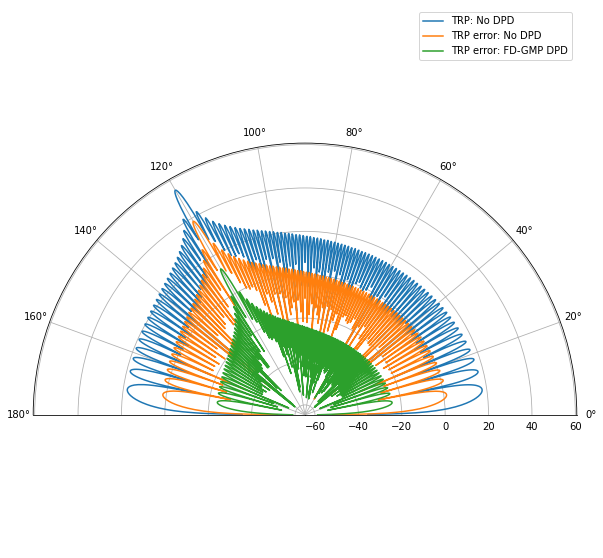

In [6]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(10, 10))
ax.set_thetamin(0)
ax.set_thetamax(180)

angles_plot = angles + np.pi/2
pow_align_for_plot= 40

ax.plot(angles_plot,TRP_NoDPD-pow_align_for_plot,label='TRP: No DPD')
ax.plot(angles_plot,TRP_error_NoDPD-pow_align_for_plot,label='TRP error: No DPD')
ax.plot(angles_plot,TRP_error_DPD-pow_align_for_plot,label='TRP error: FD-GMP DPD')

ax.legend()

ax.grid(True)

np.savez(os.path.join('Buffer_files','Pattern_TDGMP_OSR'+str(TD_DPD_OSR)+'_B100U1'),angles_plot\
         ,TRP_NoDPD,None, TRP_error_NoDPD, TRP_error_DPD)


# FD-GMP

In [7]:
from complexLayers import ComplexBatchNorm2d, ComplexConv2d, ComplexLinear
from complexFunctions import complex_relu


# This class defines both FD-GMP and FD-NN. Switch between them by set "flag_gmp" and "flag_nn" 
class FD_GMP_NN(nn.Module):
    def __init__(self,MU_flag,NN_aid_flag,NN_dims,sub_map_guardband,U=1,B=8,K_IDFT=1024,K_act=400,
                 Num_OFDMs=10,GMP_par_K=[3,0,0],GMP_par_M=[3,0,0],GMP_par_N=[0,0],NN_M=0,flag_gmp=False,
                 flag_nn=False,Num_beams=0):
        super(FD_GMP_NN, self).__init__()
        
        self.gmp_par = nn.Parameter(torch.vstack((torch.ones((1,U+Num_beams),dtype=torch.cfloat,device=device),
                                 torch.zeros((GMP_par_K[0]*(GMP_par_M[0]+1)-1,U+Num_beams),dtype=torch.cfloat,device=device,\
                                            requires_grad=True))))
        self.U=U
        self.B=B
        self.Num_beams= Num_beams
        self.K_IDFT = K_IDFT
        self.K_act = K_act
        self.sub_map_guardband = sub_map_guardband
        self.Num_OFDMs = Num_OFDMs
        self.GMP_par_K = GMP_par_K
        self.GMP_par_M = GMP_par_M
        self.GMP_par_N = GMP_par_N
        self.MU_flag=MU_flag
        self.NN_aid_flag = NN_aid_flag
        self.NN_M = NN_M
        
        self.flag_gmp = flag_gmp
        self.flag_nn = flag_nn
        
        self.fc1 = ComplexLinear(NN_dims[0], NN_dims[1])
        self.fc2 = ComplexLinear(NN_dims[1], NN_dims[2])
        
    def forward(self,in_message,Pk=None):
        ################### 2023-02-22 ###################
        x_pow = torch.sqrt(torch.mean(torch.abs(in_message)**2))
        x_IDFT_DPD = torch.zeros(self.U+self.Num_beams,self.Num_OFDMs,self.K_IDFT,device=device,dtype=torch.cfloat)
        
        x_IDFT_DPD_FD = torch.zeros(self.U,self.Num_OFDMs,self.K_IDFT,device=device,dtype=torch.cfloat)
        x_matrix_beam = torch.zeros(self.U+self.Num_beams,self.Num_OFDMs*self.K_IDFT,\
                                    self.gmp_par.shape[0],device=device,dtype=torch.cfloat)
    
        x_IDFT = torch.fft.ifft(in_message,self.K_IDFT,dim=2,norm='ortho')
        
        #If the model is FD-GMP
        if self.flag_gmp:
            for u in range(0,self.U):
                x_IDFT_reshape = torch.reshape(x_IDFT[u,:,:],(-1,1)) 
                x_matrix = memory_polynomial_model(x_IDFT_reshape, 
                                                K=self.GMP_par_K, M=self.GMP_par_M, N=self.GMP_par_N)
                dpd_out_u = x_matrix@self.gmp_par[:,u]
                dpd_out_u_reshape = torch.reshape(dpd_out_u,(self.Num_OFDMs,self.K_IDFT))
                x_IDFT_DPD[u,:,:] = dpd_out_u_reshape # For the first UE
            if self.Num_beams>0:
                x_matrix_beam[0,:,:] = Beam_domain_MP_model(x_IDFT[0,:,:].view(-1,1),x_IDFT[1,:,:].view(-1,1),\
                                                K=self.GMP_par_K, M=self.GMP_par_M, N=None)
                x_matrix_beam[1,:,:] = Beam_domain_MP_model(x_IDFT[1,:,:].view(-1,1),x_IDFT[0,:,:].view(-1,1),\
                                                K=self.GMP_par_K, M=self.GMP_par_M, N=None)
                x_matrix_beam[2,:,:(self.GMP_par_K[0]-2)*(self.GMP_par_M[0]+1)] = Beam_domain_MP_model(x_IDFT[0,:,:].view(-1,1),x_IDFT[1,:,:].view(-1,1),\
                                                K=self.GMP_par_K, M=self.GMP_par_M, N=None,flag_cross_beam3=True)
                x_matrix_beam[3,:,:(self.GMP_par_K[0]-2)*(self.GMP_par_M[0]+1)] = Beam_domain_MP_model(x_IDFT[1,:,:].view(-1,1),x_IDFT[0,:,:].view(-1,1),\
                                                K=self.GMP_par_K, M=self.GMP_par_M, N=None,flag_cross_beam3=True)
                for beam in range(self.Num_beams):
                    dpd_out_beam = torch.reshape(x_matrix_beam[beam,:,:]@self.gmp_par[:,U+beam],(self.Num_OFDMs,self.K_IDFT))
                    x_IDFT_DPD[beam,:,:] = x_IDFT_DPD[beam,:,:] + dpd_out_beam # For the beam in the direction of UE 0
            
            x_IDFT_DPD_FD = torch.fft.fft(x_IDFT_DPD,self.K_IDFT,dim=2,norm='ortho') # FFT back to frequency-domain
        #else if the model is FD-NN
        elif self.flag_nn:
            x_IDFT_mem = torch.zeros(self.Num_OFDMs*self.K_IDFT,self.U*(self.NN_M+1),device=device,dtype=torch.cfloat)

            ####### FD NN-based DPD 2023-0706 #########
            for u in range(0,self.U):
                x_IDFT_reshape = torch.reshape(x_IDFT[u,:,:],(-1,1))
                x_IDFT_mem[:,u*(self.NN_M+1):(u+1)*(self.NN_M+1)] = stack_memory_multi_dim(x_IDFT_reshape,self.NN_M,dim=1)
                
            x_u = complex_relu(self.fc1(x_IDFT_mem))
            x_u = self.fc2(x_u)
            x_IDFT_DPD = torch.reshape(x_u, (self.Num_OFDMs,self.K_IDFT,self.U))
            x_IDFT_DPD = x_IDFT_DPD.view(self.U,self.Num_OFDMs,self.K_IDFT) + x_IDFT
            x_IDFT_DPD_FD = torch.fft.fft(x_IDFT_DPD,self.K_IDFT,dim=2,norm='ortho')
            x_matrix = x_IDFT_mem 
        x = x_IDFT_DPD_FD
        return x, x_matrix


## Prepare Parameters

In [8]:
torch.manual_seed(0)
np.random.seed(0)

B = 100 # Basestation antanna size, 16
U = 1 # Number of users, 8

K_act = 16 # Active subcarries; Set K_act=256 --> 30 MHz signal, but requires a large memorysize to train
K_CP = 0 #length of cyclic prefix (must be smaller than IDFT size but larger than L)
K_act_QPSK = 0 #int(K_act/2)
K_act_64QAM = K_act - K_act_QPSK

FD_OSR = 4 # Upsampling rate in frequency-domain
K_IDFT = K_act*FD_OSR  # IDFT size & Total number of subcarries
#fd = 100e6 * K_IDFT/K_act  # symbol rate [symbol/sec]
#fs = fsfd*fd # sampling rate
sub_spacing = 1.2e5
BW=K_act*sub_spacing

sub_map_QPSK = list(range(K_IDFT-int(K_act_QPSK/2),K_IDFT)) + list(range(0,int(K_act_QPSK/2)))
sub_map_64QAM = list(range(K_IDFT-int(K_act_QPSK/2)-int(K_act_64QAM/2),K_IDFT-int(K_act_QPSK/2))) + list(range(int(K_act_QPSK/2),int(K_act_QPSK/2)+int(K_act_64QAM/2)))
sub_map_data = sub_map_64QAM + sub_map_QPSK 
sub_map_guardband = list(range(int(K_act_64QAM/2), K_IDFT-int(K_act_64QAM/2)))
sub_map_adjacent_right = list(range(K_act_64QAM//2,K_act_64QAM*3//2)) 
sub_map_adjacent_left = list(range(K_IDFT-K_act_64QAM*3//2,K_IDFT-K_act_64QAM//2))

Num_OFDMs = 10
batch_size_2 = K_act_64QAM*U*Num_OFDMs
M_2 = 256
# PA hyperparameters
pa_model = 'gmp'
# gmp = np.load('gmp.npz')
gmp_pa_K = [7,0,0] 
gmp_pa_M=[5,0,0] 
gmp_pa_N = [0,0]

NN_memory_len=5

gmp_DPD_K = [5,0,0] 
gmp_DPD_M=[5,0,0] 
gmp_DPD_N = [0,0]
weblab_gain = np.sqrt(10**(51.0/10))

# SNR for training
PAOutPowerdBm= np.arange(48,100,100)


#UE distances and locations
c_light = 3e8
d_UE = 25*np.ones((U))
tau_UE = d_UE/c_light

channel_type = 'LOS'

if channel_type is 'Rayleigh':
    fc=2e9
    #large-scale coefficient
    alpha=3.76
    sigma_sf=8
    noiseFigure=7
    constantTerm_meter= -35.3 # -35.3 dB at 1m corresponds to -148.1 dB at 1km using alpha=3.76
    #compute noise power
    noiseVardBm = -174 + 10*np.log10(BW) + noiseFigure
elif channel_type is 'LOS':
    fc=3e10
    #large-scale coefficient
    alpha=2.1
    sigma_sf=0
    noiseFigure=7
    constantTerm_meter= -61.9 # -61.9 dB at 1m
    #compute noise power
    noiseVardBm = -174 + 10*np.log10(BW) + noiseFigure

gainOverNoisedB = np.zeros(U)
UE_median_SNR = constantTerm_meter - alpha*10*np.log10(d_UE) - noiseVardBm + PAOutPowerdBm

gainOverNoise_power = torch.tensor(10**(gainOverNoisedB/10),dtype=torch.complex64).to(device)
PAOutPower_power = torch.tensor(10**((PAOutPowerdBm-10)/10),dtype=torch.complex64).to(device)

num_batch = 100


sigma_channel = 1
# Time-domain channel parameters
L = 100 # channel taps
channel_est_err= 0
TD_DPD_OSR = 4
FD_DPD_OSR = 4


## Prepare FD-GMP model

In [9]:
training_flag=True
LMS_flag=False
    
train_SNR_QPSK = np.array([])
ser_np_2= np.array([])
ser_np_snr_2=np.array([])
loss_np=np.array([])

_pow_pa_out = torch.tensor([])
_pow_pa_out_with_dpd = torch.tensor([])
_pow_pa_out_mean = torch.tensor([])

dpd_fd_gmp = FD_GMP_NN(MU_flag=False,NN_aid_flag=False,NN_dims=[U*(NN_memory_len+1),40,U], sub_map_guardband=sub_map_guardband,U=U,K_IDFT=K_IDFT,
                       K_act=K_act,Num_OFDMs=Num_OFDMs,GMP_par_K=gmp_DPD_K,GMP_par_M=gmp_DPD_M,GMP_par_N=gmp_DPD_N,
                      flag_gmp=True,flag_nn=False,NN_M=NN_memory_len,\
                      Num_beams=0).to(device)

tx_opt = tAdam(dpd_fd_gmp.parameters(), lr = 0.001)


## Training

In [10]:
evm_fd_gmp = torch.tensor([])
evm_fd_gmp_mean=torch.tensor([])
aclr_fd_gmp_DPD_Tx = torch.tensor([])
aclr_fd_gmp = torch.tensor([])
aclr_fd_gmp_mean = torch.tensor([])
nmse_fd_gmp_DPD_Tx = torch.tensor([])

for PAOutPower_power_current in PAOutPower_power:

#     name = os.path.join('Buffer_files', 'FD_MIMO_FDGMP_B1U1.pt') #
#     dpd_fd_gmp.load_state_dict(torch.load(name))
#     dpd_fd_gmp.gmp_par = torch.load(name)['gmp_par']
    
    for k in range(num_batch):
        m_2, m_one_hot_2 = one_hot_generate(batch_size_2,M_2)
        x_symbs_2, const_2 = const_map(m_2,M_2)
        x_symbs_2_real = torch.view_as_real(x_symbs_2).to(device)

        ################ S/P ###############
        x_symbs_parall = torch.zeros(U,Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)
        x_symbs_parall[:,:,sub_map_64QAM] = x_symbs_2.view(U,Num_OFDMs,K_act_64QAM).to(device)
        ############### 
        x_symbs_power_64QAM = torch.mean(torch.abs(x_symbs_parall[:,:,sub_map_64QAM])**2)


        ############## Time-domain channel matrix ##########
        if channel_type is 'Rayleigh':
            Ht = np.sqrt(0.5/L)*(torch.randn(U,B,L) + 1j*torch.randn(U,B,L)).to(device)
            Ht_est = np.sqrt(1-channel_est_err)*Ht + np.sqrt(channel_est_err/2)*(torch.randn(U,B,L) + 1j*torch.randn(U,B,L)).to(device)
            Ht_random = np.sqrt(0.5/L)*(torch.randn(U,B,L) + 1j*torch.randn(U,B,L)).to(device)

            Ht = torch.tensordot(torch.diag(gainOverNoise_power[:]),Ht,dims=([1],[0]))
            Ht_est = torch.tensordot(torch.diag(gainOverNoise_power[:]),Ht_est,dims=([1],[0]))
            Ht_random = torch.tensordot(torch.diag(gainOverNoise_power[:]),Ht_random,dims=([1],[0]))

            #########Frequency-domain channel matrix ######
            Hf = torch.fft.fft(Ht,K_IDFT,dim=2)
            Hf_est = torch.fft.fft(Ht_est,K_IDFT,dim=2)
            # Channel for a random spatial point
            Hf_random = torch.fft.fft(Ht_random,K_IDFT,dim=2)
        elif channel_type is 'LOS':
            Hf = torch.zeros(U,B,K_IDFT,dtype=torch.complex64).to(device)
#             theta_load = np.load(os.path.join('Buffer_files','Theta_'+str(TD_DPD_OSR)+'_B100U10.npz'),theta_UE)
#             theta_UE = theta_load['arr_0']
#             theta_UE = np.random.uniform(-np.pi/2,np.pi/2,U)
            theta_UE = np.array([np.pi/6,-np.pi/4])
#             p_UE = d_UE*np.exp(1j*theta_UE)
            
            Hf_random = torch.zeros(1,B,K_IDFT,dtype=torch.complex64).to(device)
            theta_random = np.random.uniform(-np.pi/2,np.pi/2,1)
            for b in range(B):
                for u in range(U):
                    steer_vec = np.exp(-1j*2*np.pi*(fc)*(tau_UE[u] + b*np.sin(theta_UE[u])/2/fc))
#                     steer_vec = np.exp(-1j*2*np.pi*(fc + np.linspace(0,K_IDFT-1,K_IDFT)*sub_spacing)*(tau_UE[u] + b*np.sin(theta_UE[u])/2/fc))
                    Hf[u,b,:] = gainOverNoise_power[u]*torch.tensor(steer_vec).to(device)
                Hf_random[0,b,:] = gainOverNoise_power[0]*torch.tensor(np.exp(1j*2*np.pi*\
                                            np.linspace(0,K_IDFT-1,K_IDFT)*sub_spacing*(tau_UE[0] + \
                                                                b*np.sin(theta_random)/fc/2))).to(device)
            Hf_est = Hf
        ############# Obtain Precoding Matrix for the FD DPD usage purpose ########
        Pf_test, beta_precod = zero_forcing(None, Hf_est,B,U,K_IDFT,Num_OFDMs,return_P_only_flag=True) 
        
        ############### FD NN DPD ###############
        dpd_out_complex_FD, dpd_in = dpd_fd_gmp(x_symbs_parall,Pk=Pf_test)
        
        ############### Precoding ##############
        xf_all = torch.zeros(B,Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)
        xf_all[:,:,sub_map_data], Pf1, beta_precod = zero_forcing(x_symbs_parall[:,:,sub_map_data], Hf_est[:,:,sub_map_data],B,U,K_act,Num_OFDMs)
        xf_all_with_dpd = torch.zeros(B,Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)
        xf_all_with_dpd[:,:,:], Pf2, beta_precod = zero_forcing(dpd_out_complex_FD[0:U,:,:]\
                                                               ,Hf_est[:,:,:],B,U,K_IDFT,Num_OFDMs)
#         xf_all_with_dpd[:,:,sub_map_guardband]= dpd_out_complex_FD[:,:,sub_map_guardband]
#         xf_all_with_dpd= 1*gain_loss_lin*xf_all_with_dpd
        
#         xf_all_with_dpd2, dpd_in2 = dpd_fd_gmp(xf_all,Pk=None)
        
        ############## IDFT of OFDM ###################
        x_n = torch.fft.ifft(xf_all,K_IDFT,dim=2,norm='ortho')
        x_n_with_dpd = torch.fft.ifft(xf_all_with_dpd,K_IDFT,dim=2,norm='ortho')

        ####### For each antenna ########
        x_n_PAs_NoDPD = torch.zeros(B,Num_OFDMs*(K_IDFT),dtype=torch.complex64).to(device)
        x_n_PAs_with_dpd = torch.zeros(B,Num_OFDMs*(K_IDFT),dtype=torch.complex64).to(device)

        for b in range(B):
            ############### P/S ################
            x_n_serial = x_n[b,:,:].view(-1)
            x_n_serial_with_dpd = x_n_with_dpd[b,:,:].view(-1)

            ############## Calculate the linear gain according to the SNR ############
            driv_gain_2=torch.sqrt(PAOutPower_power_current*K_IDFT/K_act)

            sigma_channel_true = sigma_channel #*np.sqrt(K_IDFT/K_act)

            x_tx = x_n_serial*driv_gain_2
            x_tx_with_dpd = x_n_serial_with_dpd*driv_gain_2

            x_tx_weblab = x_tx/weblab_gain
            x_tx_weblab_with_dpd = x_tx_with_dpd/weblab_gain

            ############# PA in time-domain ###########
            pa_out = PA(torch.view_as_real(x_tx_weblab),pa_model,K=gmp_pa_K,M=gmp_pa_M,b=0)
            pa_out_with_dpd = PA(torch.view_as_real(x_tx_weblab_with_dpd),\
                                     pa_model,K=gmp_pa_K,M=gmp_pa_M,b=0)
            pa_out_ideal = PA(torch.view_as_real(x_tx),'ideal',K=gmp_pa_K,M=gmp_pa_M)


            x_n_PAs_NoDPD[b,:] = torch.view_as_complex(pa_out)
            x_n_PAs_with_dpd[b,:] = torch.view_as_complex(pa_out_with_dpd)
        
        if training_flag:            
            loss = torch.mean(torch.abs(x_n_PAs_with_dpd - driv_gain_2*x_n.view(B,-1))**2)
            tx_opt.zero_grad()
            loss.backward(retain_graph=False)
            tx_opt.step()
            loss_np = np.append(loss_np,loss.to('cpu').detach().numpy())
        x_n_PAs_no_PA= x_n*driv_gain_2
    
        with torch.no_grad():
            gain_loss_lin = torch.sqrt(torch.mean(torch.abs(x_n_PAs_no_PA)**2)/torch.mean(torch.abs(x_n_PAs_NoDPD)**2))
        
        ############ Channel in Frequency-domain ##########
        xf_PAs_NoDPD = torch.fft.fft(x_n_PAs_NoDPD.view(B,Num_OFDMs,K_IDFT),K_IDFT,dim=2,norm='ortho')
        xf_PAs_with_dpd = torch.fft.fft(x_n_PAs_with_dpd.view(B,Num_OFDMs,K_IDFT),K_IDFT,dim=2,norm='ortho')#*beta_precod
        xf_PAs_no_PA = torch.fft.fft(x_n_PAs_no_PA.view(B,Num_OFDMs,K_IDFT),K_IDFT,dim=2,norm='ortho')#*beta_precod

        yf = torch.zeros(U,Num_OFDMs, K_IDFT,dtype=torch.complex64).to(device)
        yf_with_dpd = torch.zeros(U,Num_OFDMs, K_IDFT,dtype=torch.complex64).to(device)
        yf_NoDPD_random = torch.zeros(U,Num_OFDMs, K_IDFT,dtype=torch.complex64).to(device)
        yf_DPD_random = torch.zeros(U,Num_OFDMs, K_IDFT,dtype=torch.complex64).to(device)

        ####### Compute ACLR at Tx ######
        aclr_fd_gmp_DPD_Tx = torch.hstack((aclr_fd_gmp_DPD_Tx ,10*torch.log10(torch.sum(torch.abs(xf_PAs_with_dpd[:,:,sub_map_64QAM].detach().to('cpu'))**2)/\
                                torch.maximum(torch.sum(torch.abs(xf_PAs_with_dpd[:,:,sub_map_adjacent_left].detach().to('cpu'))**2), \
                                              torch.sum(torch.abs(xf_PAs_with_dpd[:,:,sub_map_adjacent_right].detach().to('cpu'))**2)))))
        ####### Compute NMSE at Tx ######
        nmse_fd_gmp_DPD_Tx = torch.hstack((nmse_fd_gmp_DPD_Tx ,10*torch.log10(torch.mean(torch.abs(\
                                  x_n_PAs_with_dpd - driv_gain_2*x_n.view(B,-1))**2) \
                                    /torch.mean(torch.abs(driv_gain_2*x_n.view(B,-1))**2)).detach().to('cpu')))
                                

        for k in range(0,K_IDFT):
            #yf[:,:,k] = Hf[:,:,k]@xf_PAs[:,:,k]
            yf[:,:,k] = complex_matrix_multi(Hf[:,:,k], xf_PAs_NoDPD[:,:,k])
            #yf_with_dpd[:,:,k] = Hf[:,:,k]@xf_PAs_with_dpd[:,:,k]
            yf_with_dpd[:,:,k] = complex_matrix_multi(Hf[:,:,k], xf_PAs_with_dpd[:,:,k])
            #yf_with_dpd = xf_PAs_with_dpd
            
#             yf_NoDPD_random[:,:,k] = Hf_random[:,:,k]@xf_PAs_NoDPD[:,:,k]
            yf_DPD_random[:,:,k] = Hf_random[:,:,k]@xf_PAs_with_dpd[:,:,k]

        y_symbs_FD = yf #+ sigma_channel_true * (torch.randn(yf.shape).to(device) + 1j*torch.randn(yf.shape).to(device))
        y_symbs_FD_with_dpd = yf_with_dpd #+ sigma_channel_true * (torch.randn(yf_with_dpd.shape).to(device) + 1j*torch.randn(yf_with_dpd.shape).to(device))
        y_symbs_FD_with_dpd_random= yf_DPD_random #+ sigma_channel_true * (torch.randn(yf_with_dpd.shape).to(device) + 1j*torch.randn(yf_with_dpd.shape).to(device))

        y_symbs_FD_with_dpd_real = torch.view_as_real(y_symbs_FD_with_dpd)
        
        ############# P/S #################
        #QAM symbols at the data subcarriers
        y_symbs_serial_64QAM = torch.view_as_complex(y_symbs_FD_with_dpd_real[:,:,sub_map_64QAM,:]) #sub_map_64QAM
        y_symbs_serial_64QAM_amplitude = torch.sqrt(torch.mean(torch.abs(y_symbs_serial_64QAM)**2))
        y_symbs_serial_64QAM_norm = y_symbs_serial_64QAM.view(-1,1)/y_symbs_serial_64QAM_amplitude
        
        #QAM symbols at all subcarriers
        y_symbs_serial_allQAM = torch.view_as_complex(y_symbs_FD_with_dpd_real[:,:,:,:]) #sub_map_64QAM
        y_symbs_serial_allQAM_norm = y_symbs_serial_allQAM.view(-1,1)/y_symbs_serial_64QAM_amplitude

        with torch.no_grad():
            #QAM symbols without DPD
            y_symbs_serial_allQAM_NoDPD = y_symbs_FD #sub_map_64QAM
            y_symbs_serial_allQAM_NoDPD_norm = y_symbs_serial_allQAM_NoDPD/\
                                            torch.sqrt(torch.mean(torch.abs(y_symbs_serial_allQAM_NoDPD[:,:,sub_map_64QAM])**2))
            #QAM symbols with DPD
            y_symbs_serial_allQAM_DPD = y_symbs_FD_with_dpd #sub_map_64QAM
            y_symbs_serial_allQAM_DPD_norm = y_symbs_serial_allQAM_DPD/\
                                            torch.sqrt(torch.mean(torch.abs(y_symbs_serial_allQAM_DPD[:,:,sub_map_64QAM])**2))
        
        ############### LMS learning of FD GMP DPD ###########
        if LMS_flag:
            with torch.no_grad():
                error_symbs = (y_symbs_serial_allQAM.view(U,-1)/7.78 - x_symbs_parall.view(U,-1)).reshape(-1,U)
                #print(torch.mean(torch.abs(error_symbs)))
                R = dpd_in.conj().T@dpd_in
                dpd_fd_gmp.gmp_par = nn.Parameter(dpd_fd_gmp.gmp_par - (LMS_mu*torch.inverse(R)@dpd_in.conj().T@error_symbs))
#                 print(torch.mean(abs(error_symbs)**2))
        
        with torch.no_grad():
            #if K_act_QPSK>0:
            y_m_2 = const_demap(y_symbs_serial_64QAM_norm,const_2.to(device),M_2)
            ser_2 = SER(y_m_2,m_2,one_hot=False)
            ser_np_2 = np.append(ser_np_2,ser_2)

        _pow_pa_out = torch.hstack((_pow_pa_out,(10*torch.log10(torch.mean(torch.abs(x_n_PAs_with_dpd.detach().to('cpu'))**2)/100) + 30)))
        
        #calculate EVM
        evm_fd_gmp = torch.hstack((evm_fd_gmp, torch.mean(torch.abs(y_symbs_serial_64QAM_norm - x_symbs_parall[:,:,sub_map_64QAM].view(-1,1))).detach().to('cpu')))
        aclr_fd_gmp = torch.hstack((aclr_fd_gmp ,10*torch.log10(torch.sum(torch.abs(y_symbs_FD_with_dpd[:,:,sub_map_64QAM].detach().to('cpu'))**2)/\
                        torch.maximum(torch.sum(torch.abs(y_symbs_FD_with_dpd[:,:,sub_map_adjacent_left].detach().to('cpu'))**2), \
                                      torch.sum(torch.abs(y_symbs_FD_with_dpd[:,:,sub_map_adjacent_right].detach().to('cpu'))**2)))))
        print('SER = ', "{:.2e}".format(ser_np_2[-1]), ', EVM =',  "{:.2f}%".format(100*evm_fd_gmp[-1]), \
              'Tx NMSE =', "{:.2f}dB".format(nmse_fd_gmp_DPD_Tx[-1]), ', OTA ACLR =',  "{:.2f}dBc".format(aclr_fd_gmp[-1]),\
                 ', Tx ACLR =',"{:.2f}dBc".format(aclr_fd_gmp_DPD_Tx[-1]), ', PA Avg output power: ', \
                  "{:.2f}dBm".format(_pow_pa_out[-1]))
        
torch.save(dpd_fd_gmp.state_dict(),os.path.join('Buffer_files', 'FD_FDGMP_LOS_B100U1.pt'))


/home/yibo/miniconda3/envs/py36_yibo/lib/python3.6/site-packages/torch/autograd/__init__.py:156: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811805959/work/aten/src/ATen/native/Copy.cpp:244.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


SER =  1.37e-01 , EVM = 5.64% Tx NMSE = -17.41dB , OTA ACLR = 31.85dBc , Tx ACLR = 31.85dBc , PA Avg output power:  26.51dBm
SER =  8.13e-02 , EVM = 4.81% Tx NMSE = -17.88dB , OTA ACLR = 30.43dBc , Tx ACLR = 30.43dBc , PA Avg output power:  26.73dBm
SER =  3.12e-02 , EVM = 4.45% Tx NMSE = -18.51dB , OTA ACLR = 31.92dBc , Tx ACLR = 31.92dBc , PA Avg output power:  26.84dBm
SER =  4.37e-02 , EVM = 4.27% Tx NMSE = -19.20dB , OTA ACLR = 32.07dBc , Tx ACLR = 32.07dBc , PA Avg output power:  27.25dBm
SER =  2.69e-01 , EVM = 7.05% Tx NMSE = -19.00dB , OTA ACLR = 30.56dBc , Tx ACLR = 30.56dBc , PA Avg output power:  26.56dBm
SER =  7.50e-02 , EVM = 4.72% Tx NMSE = -20.01dB , OTA ACLR = 32.03dBc , Tx ACLR = 32.03dBc , PA Avg output power:  27.46dBm
SER =  6.25e-02 , EVM = 4.45% Tx NMSE = -20.29dB , OTA ACLR = 31.64dBc , Tx ACLR = 31.64dBc , PA Avg output power:  27.17dBm
SER =  4.37e-02 , EVM = 4.34% Tx NMSE = -20.63dB , OTA ACLR = 30.45dBc , Tx ACLR = 30.45dBc , PA Avg output power:  27.30dBm


SER =  0.00e+00 , EVM = 3.07% Tx NMSE = -26.75dB , OTA ACLR = 32.58dBc , Tx ACLR = 32.58dBc , PA Avg output power:  27.84dBm
SER =  1.88e-02 , EVM = 3.58% Tx NMSE = -25.73dB , OTA ACLR = 30.88dBc , Tx ACLR = 30.88dBc , PA Avg output power:  27.76dBm
SER =  1.25e-02 , EVM = 3.80% Tx NMSE = -26.60dB , OTA ACLR = 32.18dBc , Tx ACLR = 32.18dBc , PA Avg output power:  28.17dBm
SER =  1.88e-02 , EVM = 4.58% Tx NMSE = -25.63dB , OTA ACLR = 31.70dBc , Tx ACLR = 31.70dBc , PA Avg output power:  27.57dBm
SER =  3.75e-02 , EVM = 4.78% Tx NMSE = -26.97dB , OTA ACLR = 32.49dBc , Tx ACLR = 32.49dBc , PA Avg output power:  28.30dBm
SER =  2.00e-01 , EVM = 6.94% Tx NMSE = -25.46dB , OTA ACLR = 31.72dBc , Tx ACLR = 31.72dBc , PA Avg output power:  27.26dBm
SER =  0.00e+00 , EVM = 2.87% Tx NMSE = -26.58dB , OTA ACLR = 32.40dBc , Tx ACLR = 32.40dBc , PA Avg output power:  27.94dBm
SER =  8.13e-02 , EVM = 4.94% Tx NMSE = -26.49dB , OTA ACLR = 31.83dBc , Tx ACLR = 31.83dBc , PA Avg output power:  28.30dBm


## Testing

In [11]:
training_flag=False

torch.manual_seed(0)
np.random.seed(0)

B = 100 # Basestation antanna size, 16
U = 1 # Number of users, 8

K_act = 16 # Active subcarries
K_CP = 0 #length of cyclic prefix (must be smaller than IDFT size but larger than L)
K_act_QPSK = 0 #int(K_act/2)
K_act_64QAM = K_act - K_act_QPSK

FD_OSR = 4 # Upsampling rate in frequency-domain
K_IDFT = K_act*FD_OSR  # IDFT size & Total number of subcarries

sub_spacing = 1.2e5
BW=K_act*sub_spacing

sub_map_QPSK = list(range(K_IDFT-int(K_act_QPSK/2),K_IDFT)) + list(range(0,int(K_act_QPSK/2)))
sub_map_64QAM = list(range(K_IDFT-int(K_act_QPSK/2)-int(K_act_64QAM/2),K_IDFT-int(K_act_QPSK/2))) + list(range(int(K_act_QPSK/2),int(K_act_QPSK/2)+int(K_act_64QAM/2)))
sub_map_data = sub_map_64QAM + sub_map_QPSK 
sub_map_guardband = list(range(int(K_act_64QAM/2), K_IDFT-int(K_act_64QAM/2)))
sub_map_adjacent_right = list(range(K_act_64QAM//2,K_act_64QAM*3//2)) 
sub_map_adjacent_left = list(range(K_IDFT-K_act_64QAM*3//2,K_IDFT-K_act_64QAM//2))

Num_OFDMs = 100
batch_size_2 = K_act_64QAM*U*Num_OFDMs
M_2 = 256
# PA hyperparameters
pa_model = 'gmp'
# gmp = np.load('gmp.npz')
gmp_pa_K = [7,0,0] 
gmp_pa_M=[5,0,0] 
gmp_pa_N = [0,0]

NN_memory_len=5

gmp_DPD_K = [5,0,0] 
gmp_DPD_M=[5,0,0] 
gmp_DPD_N = [0,0]
weblab_gain = np.sqrt(10**(51.0/10))

# SNR for training
PAOutPowerdBm= np.arange(48,100,100)

#UE distances and locations
c_light = 3e8
d_UE = 25*np.ones((U))
tau_UE = d_UE/c_light

channel_type = 'LOS'

gainOverNoisedB = np.zeros(U)
UE_median_SNR = constantTerm_meter - alpha*10*np.log10(d_UE) - noiseVardBm + PAOutPowerdBm

gainOverNoise_power = torch.tensor(10**(gainOverNoisedB/10),dtype=torch.complex64).to(device)
PAOutPower_power = torch.tensor(10**((PAOutPowerdBm-10)/10),dtype=torch.complex64).to(device)

num_batch = 1


sigma_channel = 1
# Time-domain channel parameters
L = 100 # channel taps
channel_est_err= 0#.00015
TD_DPD_OSR = 4
FD_DPD_OSR = 4


##################################################
evm_fd_gmp = torch.tensor([])
evm_fd_gmp_mean=torch.tensor([])
aclr_fd_gmp_DPD_Tx = torch.tensor([])
aclr_fd_gmp = torch.tensor([])
aclr_fd_gmp_mean = torch.tensor([])
nmse_fd_gmp_DPD_Tx = torch.tensor([])

for PAOutPower_power_current in PAOutPower_power:

    name = os.path.join('Buffer_files', 'FD_FDGMP_LOS_B100U1.pt') #
    dpd_fd_gmp.load_state_dict(torch.load(name))
    dpd_fd_gmp.Num_OFDMs=Num_OFDMs
    for k in range(num_batch):
        m_2, m_one_hot_2 = one_hot_generate(batch_size_2,M_2)
        x_symbs_2, const_2 = const_map(m_2,M_2)
        x_symbs_2_real = torch.view_as_real(x_symbs_2).to(device)

        ################ S/P ###############
        x_symbs_parall = torch.zeros(U,Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)
        x_symbs_parall[:,:,sub_map_64QAM] = x_symbs_2.view(U,Num_OFDMs,K_act_64QAM).to(device)
        ############### 
        x_symbs_power_64QAM = torch.mean(torch.abs(x_symbs_parall[:,:,sub_map_64QAM])**2)


        ############## Time-domain channel matrix ##########
        if channel_type is 'Rayleigh':
            Ht = np.sqrt(0.5/L)*(torch.randn(U,B,L) + 1j*torch.randn(U,B,L)).to(device)
            Ht_est = np.sqrt(1-channel_est_err)*Ht + np.sqrt(channel_est_err/2)*(torch.randn(U,B,L) + 1j*torch.randn(U,B,L)).to(device)
            Ht_random = np.sqrt(0.5/L)*(torch.randn(U,B,L) + 1j*torch.randn(U,B,L)).to(device)

            Ht = torch.tensordot(torch.diag(gainOverNoise_power[:]),Ht,dims=([1],[0]))
            Ht_est = torch.tensordot(torch.diag(gainOverNoise_power[:]),Ht_est,dims=([1],[0]))
            Ht_random = torch.tensordot(torch.diag(gainOverNoise_power[:]),Ht_random,dims=([1],[0]))

            #########Frequency-domain channel matrix ######
            Hf = torch.fft.fft(Ht,K_IDFT,dim=2)
            Hf_est = torch.fft.fft(Ht_est,K_IDFT,dim=2)
            # Channel for a random spatial point
            Hf_random = torch.fft.fft(Ht_random,K_IDFT,dim=2)
        elif channel_type is 'LOS':
            Hf = torch.zeros(U,B,K_IDFT,dtype=torch.complex64).to(device)
#             theta_load = np.load(os.path.join('Buffer_files','Theta_'+str(TD_DPD_OSR)+'_B100U10.npz'),theta_UE)
#             theta_UE = theta_load['arr_0']
#             theta_UE = np.random.uniform(-np.pi/2,np.pi/2,U)
            theta_UE = np.array([np.pi/6,-np.pi/4])
#             p_UE = d_UE*np.exp(1j*theta_UE)
            
            Hf_random = torch.zeros(1,B,K_IDFT,dtype=torch.complex64).to(device)
            theta_random = np.random.uniform(-np.pi/2,np.pi/2,1)
            for b in range(B):
                for u in range(U):
                    steer_vec = np.exp(-1j*2*np.pi*(fc)*(tau_UE[u] + b*np.sin(theta_UE[u])/2/fc))
#                     steer_vec = np.exp(-1j*2*np.pi*(fc + np.linspace(0,K_IDFT-1,K_IDFT)*sub_spacing)*(tau_UE[u] + b*np.sin(theta_UE[u])/2/fc))
                    Hf[u,b,:] = gainOverNoise_power[u]*torch.tensor(steer_vec).to(device)
                Hf_random[0,b,:] = gainOverNoise_power[0]*torch.tensor(np.exp(1j*2*np.pi*\
                                            np.linspace(0,K_IDFT-1,K_IDFT)*sub_spacing*(tau_UE[0] + \
                                                                b*np.sin(theta_random)/fc/2))).to(device)
            Hf_est = Hf
        ############# Obtain Precoding Matrix for the FD DPD usage purpose ########
        Pf_test, beta_precod = zero_forcing(None, Hf_est,B,U,K_IDFT,Num_OFDMs,return_P_only_flag=True) 
        
        ############### FD NN DPD ###############
        dpd_out_complex_FD, dpd_in = dpd_fd_gmp(x_symbs_parall,Pk=Pf_test)
        
        ############### Precoding ##############
        xf_all = torch.zeros(B,Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)
        xf_all[:,:,sub_map_data], Pf1, beta_precod = zero_forcing(x_symbs_parall[:,:,sub_map_data], Hf_est[:,:,sub_map_data],B,U,K_act,Num_OFDMs)
        xf_all_with_dpd = torch.zeros(B,Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)
        xf_all_with_dpd[:,:,:], Pf2, beta_precod = zero_forcing(dpd_out_complex_FD[0:U,:,:]\
                                                               ,Hf_est[:,:,:],B,U,K_IDFT,Num_OFDMs)
        
        ############## IDFT of OFDM ###################
        x_n = torch.fft.ifft(xf_all,K_IDFT,dim=2,norm='ortho')
        x_n_with_dpd = torch.fft.ifft(xf_all_with_dpd,K_IDFT,dim=2,norm='ortho')

        ####### For each antenna ########
        x_n_PAs_NoDPD = torch.zeros(B,Num_OFDMs*(K_IDFT),dtype=torch.complex64).to(device)
        x_n_PAs_with_dpd = torch.zeros(B,Num_OFDMs*(K_IDFT),dtype=torch.complex64).to(device)

        for b in range(B):
            ############### P/S ################
            x_n_serial = x_n[b,:,:].view(-1)
            x_n_serial_with_dpd = x_n_with_dpd[b,:,:].view(-1)

            ############## Calculate the linear gain according to the SNR ############
            driv_gain_2=torch.sqrt(PAOutPower_power_current*K_IDFT/K_act)

            sigma_channel_true = sigma_channel #*np.sqrt(K_IDFT/K_act)

            x_tx = x_n_serial*driv_gain_2
            x_tx_with_dpd = x_n_serial_with_dpd*driv_gain_2

            x_tx_weblab = x_tx/weblab_gain
            x_tx_weblab_with_dpd = x_tx_with_dpd/weblab_gain

            ############# PA in time-domain ###########
            pa_out = PA(torch.view_as_real(x_tx_weblab),pa_model,K=gmp_pa_K,M=gmp_pa_M,b=0)
            pa_out_with_dpd = PA(torch.view_as_real(x_tx_weblab_with_dpd),\
                                     pa_model,K=gmp_pa_K,M=gmp_pa_M,b=0)
            pa_out_ideal = PA(torch.view_as_real(x_tx),'ideal',K=gmp_pa_K,M=gmp_pa_M)


            x_n_PAs_NoDPD[b,:] = torch.view_as_complex(pa_out)
            x_n_PAs_with_dpd[b,:] = torch.view_as_complex(pa_out_with_dpd)
        
        if training_flag:            
            loss = torch.mean(torch.abs(x_n_PAs_with_dpd - driv_gain_2*x_n.view(B,-1))**2)
            tx_opt.zero_grad()
            loss.backward(retain_graph=False)
            tx_opt.step()
            loss_np = np.append(loss_np,loss.to('cpu').detach().numpy())
        x_n_PAs_no_PA= x_n*driv_gain_2
    
        with torch.no_grad():
            gain_loss_lin = torch.sqrt(torch.mean(torch.abs(x_n_PAs_no_PA)**2)/torch.mean(torch.abs(x_n_PAs_NoDPD)**2))
        
        ############ Channel in Frequency-domain ##########
        xf_PAs_NoDPD = torch.fft.fft(x_n_PAs_NoDPD.view(B,Num_OFDMs,K_IDFT),K_IDFT,dim=2,norm='ortho')
        xf_PAs_with_dpd = torch.fft.fft(x_n_PAs_with_dpd.view(B,Num_OFDMs,K_IDFT),K_IDFT,dim=2,norm='ortho')#*beta_precod
        xf_PAs_no_PA = torch.fft.fft(x_n_PAs_no_PA.view(B,Num_OFDMs,K_IDFT),K_IDFT,dim=2,norm='ortho')#*beta_precod

        yf = torch.zeros(U,Num_OFDMs, K_IDFT,dtype=torch.complex64).to(device)
        yf_with_dpd = torch.zeros(U,Num_OFDMs, K_IDFT,dtype=torch.complex64).to(device)
        yf_NoDPD_random = torch.zeros(U,Num_OFDMs, K_IDFT,dtype=torch.complex64).to(device)
        yf_DPD_random = torch.zeros(U,Num_OFDMs, K_IDFT,dtype=torch.complex64).to(device)

        ####### Compute ACLR at Tx ######
        aclr_fd_gmp_DPD_Tx = torch.hstack((aclr_fd_gmp_DPD_Tx ,10*torch.log10(torch.sum(torch.abs(xf_PAs_with_dpd[:,:,sub_map_64QAM].detach().to('cpu'))**2)/\
                                torch.maximum(torch.sum(torch.abs(xf_PAs_with_dpd[:,:,sub_map_adjacent_left].detach().to('cpu'))**2), \
                                              torch.sum(torch.abs(xf_PAs_with_dpd[:,:,sub_map_adjacent_right].detach().to('cpu'))**2)))))
        ####### Compute NMSE at Tx ######
        nmse_fd_gmp_DPD_Tx = torch.hstack((nmse_fd_gmp_DPD_Tx ,10*torch.log10(torch.mean(torch.abs(\
                                  x_n_PAs_with_dpd - driv_gain_2*x_n.view(B,-1))**2) \
                                    /torch.mean(torch.abs(driv_gain_2*x_n.view(B,-1))**2)).detach().to('cpu')))
                                

        for k in range(0,K_IDFT):
            #yf[:,:,k] = Hf[:,:,k]@xf_PAs[:,:,k]
            yf[:,:,k] = complex_matrix_multi(Hf[:,:,k], xf_PAs_NoDPD[:,:,k])
            #yf_with_dpd[:,:,k] = Hf[:,:,k]@xf_PAs_with_dpd[:,:,k]
            yf_with_dpd[:,:,k] = complex_matrix_multi(Hf[:,:,k], xf_PAs_with_dpd[:,:,k])
            #yf_with_dpd = xf_PAs_with_dpd
            
#             yf_NoDPD_random[:,:,k] = Hf_random[:,:,k]@xf_PAs_NoDPD[:,:,k]
            yf_DPD_random[:,:,k] = Hf_random[:,:,k]@xf_PAs_with_dpd[:,:,k]

        y_symbs_FD = yf + sigma_channel_true * (torch.randn(yf.shape).to(device) + 1j*torch.randn(yf.shape).to(device))
        y_symbs_FD_with_dpd = yf_with_dpd + sigma_channel_true * (torch.randn(yf_with_dpd.shape).to(device) + 1j*torch.randn(yf_with_dpd.shape).to(device))
        y_symbs_FD_with_dpd_random= yf_DPD_random + sigma_channel_true * (torch.randn(yf_with_dpd.shape).to(device) + 1j*torch.randn(yf_with_dpd.shape).to(device))

        y_symbs_FD_with_dpd_real = torch.view_as_real(y_symbs_FD_with_dpd)
        
        ############# P/S #################
        #QAM symbols at the data subcarriers
        y_symbs_serial_64QAM = torch.view_as_complex(y_symbs_FD_with_dpd_real[:,:,sub_map_64QAM,:]) #sub_map_64QAM
        y_symbs_serial_64QAM_amplitude = torch.sqrt(torch.mean(torch.abs(y_symbs_serial_64QAM)**2))
        y_symbs_serial_64QAM_norm = y_symbs_serial_64QAM.view(-1,1)/y_symbs_serial_64QAM_amplitude
        
        #QAM symbols at all subcarriers
        y_symbs_serial_allQAM = torch.view_as_complex(y_symbs_FD_with_dpd_real[:,:,:,:]) #sub_map_64QAM
        y_symbs_serial_allQAM_norm = y_symbs_serial_allQAM.view(-1,1)/y_symbs_serial_64QAM_amplitude

        with torch.no_grad():
            #QAM symbols without DPD
            y_symbs_serial_allQAM_NoDPD = y_symbs_FD #sub_map_64QAM
            y_symbs_serial_allQAM_NoDPD_norm = y_symbs_serial_allQAM_NoDPD/\
                                            torch.sqrt(torch.mean(torch.abs(y_symbs_serial_allQAM_NoDPD[:,:,sub_map_64QAM])**2))
            #QAM symbols with DPD
            y_symbs_serial_allQAM_DPD = y_symbs_FD_with_dpd #sub_map_64QAM
            y_symbs_serial_allQAM_DPD_norm = y_symbs_serial_allQAM_DPD/\
                                            torch.sqrt(torch.mean(torch.abs(y_symbs_serial_allQAM_DPD[:,:,sub_map_64QAM])**2))
        
        ############### LMS learning of FD GMP DPD ###########
        if LMS_flag:
            with torch.no_grad():
                error_symbs = (y_symbs_serial_allQAM.view(U,-1)/7.78 - x_symbs_parall.view(U,-1)).reshape(-1,U)
                #print(torch.mean(torch.abs(error_symbs)))
                R = dpd_in.conj().T@dpd_in
                dpd_fd_gmp.gmp_par = nn.Parameter(dpd_fd_gmp.gmp_par - (LMS_mu*torch.inverse(R)@dpd_in.conj().T@error_symbs))
#                 print(torch.mean(abs(error_symbs)**2))
        
        with torch.no_grad():
            #if K_act_QPSK>0:
            y_m_2 = const_demap(y_symbs_serial_64QAM_norm,const_2.to(device),M_2)
            ser_2 = SER(y_m_2,m_2,one_hot=False)
            ser_np_2 = np.append(ser_np_2,ser_2)

        _pow_pa_out = torch.hstack((_pow_pa_out,(10*torch.log10(torch.mean(torch.abs(x_n_PAs_with_dpd.detach().to('cpu'))**2)/100) + 30)))
        
        #calculate EVM
        evm_fd_gmp = torch.hstack((evm_fd_gmp, torch.mean(torch.abs(y_symbs_serial_64QAM_norm - x_symbs_parall[:,:,sub_map_64QAM].view(-1,1))).detach().to('cpu')))
        aclr_fd_gmp = torch.hstack((aclr_fd_gmp ,10*torch.log10(torch.sum(torch.abs(y_symbs_FD_with_dpd[:,:,sub_map_64QAM].detach().to('cpu'))**2)/\
                        torch.maximum(torch.sum(torch.abs(y_symbs_FD_with_dpd[:,:,sub_map_adjacent_left].detach().to('cpu'))**2), \
                                      torch.sum(torch.abs(y_symbs_FD_with_dpd[:,:,sub_map_adjacent_right].detach().to('cpu'))**2)))))
        print('SER = ', "{:.2e}".format(ser_np_2[-1]), ', EVM =',  "{:.2f}%".format(100*evm_fd_gmp[-1]), \
              'Tx NMSE =', "{:.2f}dB".format(nmse_fd_gmp_DPD_Tx[-1]), ', OTA ACLR =',  "{:.2f}dBc".format(aclr_fd_gmp[-1]),\
                 ', Tx ACLR =',"{:.2f}dBc".format(aclr_fd_gmp_DPD_Tx[-1]), ', PA Avg output power: ', \
                  "{:.2f}dBm".format(_pow_pa_out[-1]))


SER =  0.00e+00 , EVM = 2.65% Tx NMSE = -27.14dB , OTA ACLR = 32.67dBc , Tx ACLR = 32.68dBc , PA Avg output power:  27.96dBm


## Plot beampattern

### Calculation

In [12]:
yf_NoDPD_angle = torch.zeros(Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)
yf_DPD_angle = torch.zeros(Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)
yf_NoPA_angle = torch.zeros(Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)

num_angles =1000
angles = np.linspace(-np.pi/2,np.pi/2,num_angles)
Hf_angle = torch.zeros(num_angles,B,K_IDFT,dtype=torch.complex64).to(device)


TRP_error_NoDPD = torch.zeros(num_angles)
TRP_error_DPD = torch.zeros(num_angles)
TRP_NoDPD = torch.zeros(num_angles)
TRP_DPD = torch.zeros(num_angles)

for i in range(num_angles):
    for b in range(B):
        steer_vec = np.exp(-1j*2*np.pi*(fc+np.linspace(0,K_IDFT-1,K_IDFT)*sub_spacing)*(\
                                               b*np.sin(angles[i])/2/fc))
        Hf_angle[i,b,:] = torch.tensor(steer_vec).to(device)

    for k in range(0,K_IDFT):
        yf_NoDPD_angle[:,k] = Hf_angle[i,:,k]@xf_PAs_NoDPD[:,:,k]
        yf_DPD_angle[:,k] = Hf_angle[i,:,k]@xf_PAs_with_dpd[:,:,k]
        yf_NoPA_angle[:,k] = Hf_angle[i,:,k]@xf_PAs_no_PA[:,:,k]

    yf_NoDPD_symbs_angle = yf_NoDPD_angle + 0.001*(sigma_channel_true * (torch.randn(yf_NoDPD_angle.shape).to(device) + 1j*torch.randn(yf_NoDPD_angle.shape).to(device)))
    yf_DPD_symbs_angle = yf_DPD_angle + 0.001*(sigma_channel_true * (torch.randn(yf_DPD_angle.shape).to(device) + 1j*torch.randn(yf_DPD_angle.shape).to(device)))
    
    TRP_error_NoDPD[i] = 10*torch.log10(torch.sum(abs(yf_NoDPD_symbs_angle[:,:]-yf_NoPA_angle[:,:]).detach().to('cpu')**2))
    TRP_error_DPD[i] = 10*torch.log10(torch.sum(abs(yf_DPD_symbs_angle[:,:]-yf_NoPA_angle[:,:]).detach().to('cpu')**2))
    TRP_NoDPD[i] = 10*torch.log10(torch.sum(abs(yf_NoDPD_symbs_angle[:,:]).detach().to('cpu')**2))
    TRP_DPD[i] = 10*torch.log10(torch.sum(abs(yf_DPD_symbs_angle[:,:]).detach().to('cpu')**2))


### Plot

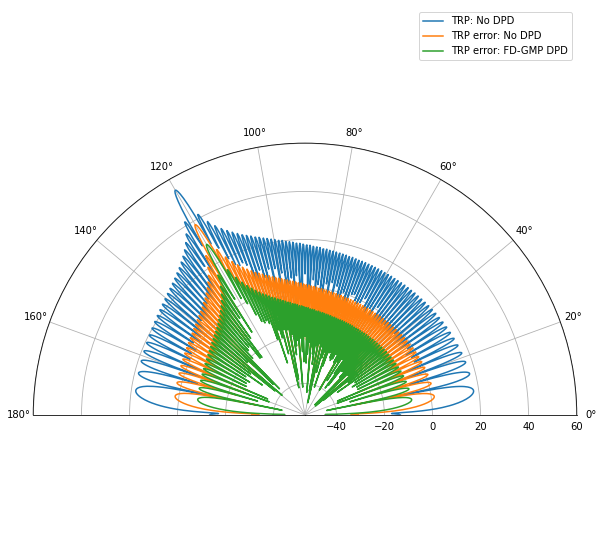

In [13]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(10, 10))
ax.set_thetamin(0)
ax.set_thetamax(180)

angles_plot = angles + np.pi/2
pow_align_for_plot= 40

ax.plot(angles_plot,TRP_NoDPD-pow_align_for_plot,label='TRP: No DPD')
ax.plot(angles_plot,TRP_error_NoDPD-pow_align_for_plot,label='TRP error: No DPD')
ax.plot(angles_plot,TRP_error_DPD-pow_align_for_plot,label='TRP error: FD-GMP DPD')
ax.legend()
ax.grid(True)

np.savez(os.path.join('Buffer_files','Pattern_FDGMP_OSR'+str(TD_DPD_OSR)+'_B100U1.npz'),angles_plot\
         ,TRP_NoDPD,None, TRP_error_NoDPD, TRP_error_DPD)


# FD-CNN

## Prepare parameters

In [14]:
torch.manual_seed(0)
np.random.seed(0)

# Start with B=1 antenna, which speeds up the training 
B = 1 # Basestation antanna size
U = 1 # Number of users

K_act = 16 # Active subcarries
K_CP = 0 #length of cyclic prefix (must be smaller than IDFT size but larger than L)
K_act_QPSK = 0 #int(K_act/2)
K_act_64QAM = K_act - K_act_QPSK

FD_OSR=4
K_IDFT = K_act*FD_OSR  # IDFT size & Total number of subcarries
sub_spacing = 1.2e5
BW=K_act*sub_spacing

#sub_map = list(range(K_IDFT-int(K_act/2),K_IDFT)) + list(range(0,int(K_act/2)))
sub_map_QPSK = list(range(K_IDFT-int(K_act_QPSK/2),K_IDFT)) + list(range(0,int(K_act_QPSK/2)))
sub_map_64QAM = list(range(K_IDFT-int(K_act_QPSK/2)-int(K_act_64QAM/2),K_IDFT-int(K_act_QPSK/2))) + list(range(int(K_act_QPSK/2),int(K_act_QPSK/2)+int(K_act_64QAM/2)))
sub_map_data = sub_map_64QAM + sub_map_QPSK 
sub_map_guardband = list(range(int(K_act_64QAM/2), K_IDFT-int(K_act_64QAM/2)))
sub_map_adjacent_right = list(range(K_act_64QAM//2,K_act_64QAM*3//2)) 
sub_map_adjacent_left = list(range(K_IDFT-K_act_64QAM*3//2,K_IDFT-K_act_64QAM//2))

K_train_in = K_IDFT
K_train_out = K_IDFT #K_act_64QAM

sub_map_train_in = list(range(0,K_IDFT)) #sub_map_data #
sub_map_train_out = sub_map_data#sub_map_64QAM #


Freq_mask =  sub_map_QPSK + list(range(int(K_act/2), K_IDFT-int(K_act/2))) # Frequency mask for subcarriers without DPD

Num_OFDMs = 100
batch_size_1 = K_act_QPSK*U*Num_OFDMs
batch_size_2 = K_act_64QAM*U*Num_OFDMs
M_1 = 256
M_2 = 256
# PA hyperparameters
pa_model = 'gmp'
gmp = np.load('gmp.npz')
gmp_pa_K = [7,0,0] 
gmp_pa_M=[5,0,0] 
gmp_pa_N=[0,0] 

weblab_gain = np.sqrt(10**(51.0/10))

memory_len=5

# SNR for training
# train_SNR = np.arange(13,17,100) # 28
PAOutPowerdBm= np.arange(28,100,100)

#Align array power by the array gain so that UE receive the same power for any B and U
# PAOutPowerdBm = PAOutPowerdBm-10*np.log10(B/U)

#UE distances and locations
c_light = 3e8
d_UE = 25*np.ones((U))
tau_UE = d_UE/c_light

channel_type = 'LOS'

if channel_type is 'Rayleigh':
    fc=2e9
    #large-scale coefficient
    alpha=3.76
    sigma_sf=8
    noiseFigure=7
    constantTerm_meter= -35.3 # -35.3 dB at 1m corresponds to -148.1 dB at 1km using alpha=3.76
    #compute noise power
    noiseVardBm = -174 + 10*np.log10(BW) + noiseFigure
elif channel_type is 'LOS':
    fc=3e10
    #large-scale coefficient
    alpha=2.1
    sigma_sf=0
    noiseFigure=7
    constantTerm_meter= -61.9 # -61.9 dB at 1m
    #compute noise power
    noiseVardBm = -174 + 10*np.log10(BW) + noiseFigure

gainOverNoisedB = np.zeros(U)
UE_median_SNR = constantTerm_meter - alpha*10*np.log10(d_UE) - noiseVardBm + \
                    PAOutPowerdBm-10*np.log10(B*FD_OSR/U)

gainOverNoise_power = torch.tensor(10**(gainOverNoisedB/10),dtype=torch.complex64).to(device)
PAOutPower_power = torch.tensor(10**((PAOutPowerdBm-10)/10),dtype=torch.complex64).to(device)

num_batch = 1000


sigma_channel = 1
# Time-domain channel parameters
L = 100 # channel taps
channel_est_err= 0#.00015
TD_DPD_OSR = 4
FD_DPD_OSR = 4


## Prepare FD-CNN model

In [15]:
training_flag=True

# Initial NN-based DPD
num_CN= [10,2] 
num_fc1_in= 2*int(K_train_in) # consider both the real and complex parts
num_fc1_out= 2*K_train_out # 
dpd_submap=list(range(0,K_train_out)) #sub_map_data#
dpd_fd_cnn = FD_CNN_MU_V2(num_CN=num_CN,num_fc1=[num_fc1_in,num_fc1_out],submap=dpd_submap,U=1,K_act=K_act).to(device)

# dpd_fd_cnn.cn0.weight.data.fill_(0.0)
# dpd_fd_cnn.cn0.bias.data.fill_(0.0)
# dpd_fd_cnn.cn1.weight.data.fill_(0.0)
# dpd_fd_cnn.cn1.bias.data.fill_(0.0)
# dpd_fd_cnn.fc1.weight.data.fill_(0.0)
# dpd_fd_cnn.fc1.bias.data.fill_(0.0)

tx_opt = tAdam(dpd_fd_cnn.parameters(), lr = 0.001)

train_SNR_QPSK = np.array([])
ser_np_1= np.array([])
ser_np_2= np.array([])
ser_np_snr_1=np.array([])
ser_np_snr_2=np.array([])
loss_np=np.array([])

_pow_pa_out = torch.tensor([])
_pow_pa_out_mean = torch.tensor([])

## Training
1. Train with B=1 antenna, which speeds up the learning of FD-CNN
2. Test the pre-trained FD-CNN with B=100 antennas


In [16]:
evm_fd_cnn = torch.tensor([])
evm_fd_cnn_mean=torch.tensor([])
aclr_fd_cnn = torch.tensor([])
aclr_fd_cnn_mean=torch.tensor([])
aclr_fd_cnn_DPD_Tx= torch.tensor([])
nmse_fd_cnn_DPD_Tx= torch.tensor([])

for PAOutPower_power_current in PAOutPower_power:
#     name = os.path.join('Buffer_files', 'FD_CNN_LOS_B100U1.pt')
#     dpd_fd_cnn.load_state_dict(torch.load(name))
#     tx_opt = tAdam(dpd_fd_cnn.parameters(), lr = 0.001)

    for k in range(num_batch):
        
        m_2, m_one_hot_2 = one_hot_generate(batch_size_2,M_2)
        x_symbs_2, const_2 = const_map(m_2,M_2)
        x_symbs_2_real = torch.view_as_real(x_symbs_2).to(device)

        ################ S/P ###############
        x_symbs_parall = torch.zeros(U,Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)
        x_symbs_parall[:,:,sub_map_64QAM] = x_symbs_2.view(U,Num_OFDMs,K_act_64QAM).to(device)
        ############### 
        x_symbs_power_64QAM = torch.mean(torch.abs(x_symbs_parall[:,:,sub_map_64QAM])**2)
        ############### FD CNN DPD ###############
        x_symbs_parall_real = torch.reshape(torch.view_as_real(x_symbs_parall[:,:,sub_map_train_in]),(-1,K_train_in,2)).transpose(1,2)
        # Convert the input size to: batch_size*channel_size*image_width*image_height        
        dpd_input = x_symbs_parall_real.view(-1,2,int(np.sqrt(K_train_in)),int(np.sqrt(K_train_in)))
        dpd_out = torch.reshape(dpd_fd_cnn(dpd_input), (-1,2,K_train_out*dpd_fd_cnn.U))
        dpd_out_complex = dpd_out[:,0,:].type(torch.complex64) + 1j*dpd_out[:,1,:].type(torch.complex64)
        dpd_out_complex = torch.reshape(dpd_out_complex, (U,Num_OFDMs,K_train_out))
              
        dpd_out_complex_all = x_symbs_parall[:,:,:] + 0
        dpd_out_complex_all[:,:,:] = dpd_out_complex
        
        ############## Time-domain channel matrix ##########
        if channel_type is 'Rayleigh':
            Ht = np.sqrt(0.5/L)*(torch.randn(U,B,L) + 1j*torch.randn(U,B,L)).to(device)
            Ht_est = np.sqrt(1-channel_est_err)*Ht + np.sqrt(channel_est_err/2)*(torch.randn(U,B,L) + 1j*torch.randn(U,B,L)).to(device)
            Ht_random = np.sqrt(0.5/L)*(torch.randn(U,B,L) + 1j*torch.randn(U,B,L)).to(device)

            Ht = torch.tensordot(torch.diag(gainOverNoise_power[:]),Ht,dims=([1],[0]))
            Ht_est = torch.tensordot(torch.diag(gainOverNoise_power[:]),Ht_est,dims=([1],[0]))
            Ht_random = torch.tensordot(torch.diag(gainOverNoise_power[:]),Ht_random,dims=([1],[0]))

            #########Frequency-domain channel matrix ######
            Hf = torch.fft.fft(Ht,K_IDFT,dim=2)
            Hf_est = torch.fft.fft(Ht_est,K_IDFT,dim=2)
            # Channel for a random spatial point
            Hf_random = torch.fft.fft(Ht_random,K_IDFT,dim=2)
        elif channel_type is 'LOS':
            Hf = torch.zeros(U,B,K_IDFT,dtype=torch.complex64).to(device)
            theta_UE = np.array([np.pi/6,-np.pi/4])
            
            Hf_random = torch.zeros(1,B,K_IDFT,dtype=torch.complex64).to(device)
            theta_random = np.random.uniform(-np.pi/2,np.pi/2,1)
            for b in range(B):
                for u in range(U):
                    steer_vec = np.exp(-1j*2*np.pi*(fc)*(tau_UE[u] + b*np.sin(theta_UE[u])/2/fc))

                    Hf[u,b,:] = gainOverNoise_power[u]*torch.tensor(steer_vec).to(device)
                Hf_random[0,b,:] = gainOverNoise_power[0]*torch.tensor(np.exp(1j*2*np.pi*\
                                            np.linspace(0,K_IDFT-1,K_IDFT)*sub_spacing*(tau_UE[0] + \
                                                                b*np.sin(theta_random)/fc/2))).to(device)
            Hf_est = Hf
        
        ############### Precoding ##############
        xf_all = torch.zeros(B,Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)
        xf_all[:,:,sub_map_data], Pf1, beta_precod = zero_forcing(x_symbs_parall[:,:,sub_map_data], Hf_est[:,:,sub_map_data],B,U,K_act,Num_OFDMs)
        xf_all_with_dpd = torch.zeros(B,Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)
        xf_all_with_dpd[:,:,:], Pf2, beta_precod = zero_forcing(dpd_out_complex_all[:,:,:],\
                                                               Hf_est[:,:,:],B,U,K_IDFT,Num_OFDMs)
        #To reduce FD-CNN complexity further, only do precoding on data subcarriers
#         xf_all_with_dpd[:,:,sub_map_data], Pf2, beta_precod = zero_forcing(dpd_out_complex_all[:,:,sub_map_data],\
#                                                                Hf_est[:,:,sub_map_data],B,U,K_act,Num_OFDMs)
        ############## IDFT of OFDM ###################
        x_n = torch.fft.ifft(xf_all,K_IDFT,dim=2,norm='ortho')
        x_n_with_dpd = torch.fft.ifft(xf_all_with_dpd,K_IDFT,dim=2,norm='ortho')

        ####### For each antenna ########
        x_n_PAs = torch.zeros(B,Num_OFDMs*(K_IDFT),dtype=torch.complex64).to(device)
        x_n_PAs_with_dpd = torch.zeros(B,Num_OFDMs*(K_IDFT),dtype=torch.complex64).to(device)

        for b in range(B):
            ############### P/S ################
            x_n_serial = x_n[b,:,:].view(-1)
            x_n_serial_with_dpd = x_n_with_dpd[b,:,:].view(-1)

            ############## Calculate the linear gain according to the SNR ############
            driv_gain_2=torch.sqrt(PAOutPower_power_current*K_IDFT/K_act)
            sigma_channel_true = sigma_channel#*np.sqrt(K_IDFT/K_act)

            
            x_tx = x_n_serial*driv_gain_2
            x_tx_with_dpd = x_n_serial_with_dpd*driv_gain_2

            x_tx_weblab = x_tx/weblab_gain
            x_tx_weblab_with_dpd = x_tx_with_dpd/weblab_gain

            ############# PA in time-domain ###########
            pa_out = PA(torch.view_as_real(x_tx_weblab),pa_model,K=gmp_pa_K,M=gmp_pa_M,b=0)
            pa_out_with_dpd = PA(torch.view_as_real(x_tx_weblab_with_dpd),pa_model,K=gmp_pa_K,M=gmp_pa_M,b=0)
            #pa_out_with_dpd = torch.view_as_real(x_tx_with_dpd) 
            pa_out_ideal = PA(torch.view_as_real(x_tx),'ideal',K=gmp_pa_K,M=gmp_pa_M)

            x_n_PAs[b,:] = torch.view_as_complex(pa_out)
            x_n_PAs_with_dpd[b,:] = torch.view_as_complex(pa_out_with_dpd)
        ########### Loss function #########
        if training_flag:
            loss = torch.mean(torch.abs(x_n_PAs_with_dpd - driv_gain_2*x_n.view(B,-1))**2)
            tx_opt.zero_grad()
            loss.backward(retain_graph=False)
            tx_opt.step()
            loss_np = np.append(loss_np,loss.to('cpu').detach().numpy())
        
        with torch.no_grad():
            gain_loss_lin = torch.sqrt(torch.mean(torch.abs(x_n*driv_gain_2)**2)/torch.mean(torch.abs(x_n_PAs)**2))

        ############ Channel in Frequency-domain ##########
        xf_PAs = torch.fft.fft(x_n_PAs.view(B,Num_OFDMs,K_IDFT),K_IDFT,dim=2,norm='ortho')
        xf_PAs_with_dpd = torch.fft.fft(x_n_PAs_with_dpd.view(B,Num_OFDMs,K_IDFT),K_IDFT,dim=2,norm='ortho')#*beta_precod
        yf = torch.zeros(U,Num_OFDMs, K_IDFT,dtype=torch.complex64).to(device)
        yf_with_dpd = torch.zeros(U,Num_OFDMs, K_IDFT,dtype=torch.complex64).to(device)
        
        ####### Compute ACLR at Tx ######
        with torch.no_grad():
            aclr_fd_cnn_DPD_Tx = torch.hstack((aclr_fd_cnn_DPD_Tx ,10*torch.log10(torch.sum(torch.abs(xf_PAs_with_dpd[:,:,sub_map_64QAM].detach().to('cpu'))**2)/\
                                    torch.maximum(torch.sum(torch.abs(xf_PAs_with_dpd[:,:,sub_map_adjacent_left].detach().to('cpu'))**2), \
                                                  torch.sum(torch.abs(xf_PAs_with_dpd[:,:,sub_map_adjacent_right].detach().to('cpu'))**2)))))
        ####### Compute NMSE at Tx ######
            nmse_fd_cnn_DPD_Tx = torch.hstack((nmse_fd_cnn_DPD_Tx ,10*torch.log10(torch.mean(torch.abs(\
                                  x_n_PAs_with_dpd - driv_gain_2*x_n.view(B,-1))**2) \
                                    /torch.mean(torch.abs(driv_gain_2*x_n.view(B,-1))**2)).detach().to('cpu')))

        for k in range(0,K_IDFT):
            #yf[:,:,k] = Hf[:,:,k]@xf_PAs[:,:,k]
            yf[:,:,k] = complex_matrix_multi(Hf[:,:,k], xf_PAs[:,:,k])
            #yf_with_dpd[:,:,k] = Hf[:,:,k]@xf_PAs_with_dpd[:,:,k]
            yf_with_dpd[:,:,k] = complex_matrix_multi(Hf[:,:,k], xf_PAs_with_dpd[:,:,k])
            #yf_with_dpd = xf_PAs_with_dpd
            
        y_symbs_FD = yf #+ sigma_channel_true * (torch.randn(yf.shape).to(device) + 1j*torch.randn(yf.shape).to(device))
        y_symbs_FD_with_dpd = yf_with_dpd #+ sigma_channel_true * (torch.randn(yf_with_dpd.shape).to(device) + 1j*torch.randn(yf_with_dpd.shape).to(device))
        y_symbs_FD_with_dpd_real = torch.view_as_real(y_symbs_FD_with_dpd)
        
        ############# P/S #################
        y_symbs_serial_64QAM = torch.view_as_complex(y_symbs_FD_with_dpd_real[:,:,sub_map_64QAM,:]).view(-1,1)
        y_symbs_serial_64QAM_amplitude = torch.sqrt(torch.mean(torch.abs(y_symbs_serial_64QAM)**2))
        y_symbs_serial_64QAM_norm = y_symbs_serial_64QAM/y_symbs_serial_64QAM_amplitude
        
        #QAM symbols at all subcarriers
        y_symbs_FD_allQAM = yf_with_dpd #sub_map_64QAM
        y_symbs_FD_allQAM_norm = y_symbs_FD_allQAM/y_symbs_serial_64QAM_amplitude
        
        y_symbs_FD_allQAM_NoDPD = yf #sub_map_64QAM
        y_symbs_FD_allQAM_norm_NoDPD = y_symbs_FD_allQAM_NoDPD/y_symbs_serial_64QAM_amplitude
        
        with torch.no_grad():
            #if K_act_QPSK>0:
            y_m_2 = const_demap(y_symbs_serial_64QAM_norm,const_2.to(device),M_2)
            ser_2 = SER(y_m_2,m_2,one_hot=False)
            ser_np_2 = np.append(ser_np_2,ser_2)
        evm_fd_cnn = torch.hstack((evm_fd_cnn, torch.mean(torch.abs(y_symbs_serial_64QAM_norm - x_symbs_parall[:,:,sub_map_64QAM].view(-1,1))).detach().to('cpu')))
        aclr_fd_cnn = torch.hstack((aclr_fd_cnn ,10*torch.log10(torch.sum(torch.abs(y_symbs_FD_with_dpd[:,:,sub_map_64QAM].detach().to('cpu'))**2)/\
                        torch.maximum(torch.sum(torch.abs(y_symbs_FD_with_dpd[:,:,sub_map_adjacent_left].detach().to('cpu'))**2), \
                                      torch.sum(torch.abs(y_symbs_FD_with_dpd[:,:,sub_map_adjacent_right].detach().to('cpu'))**2)))))
        _pow_pa_out = torch.hstack((_pow_pa_out,(10*torch.log10(torch.mean(torch.abs(x_n_PAs_with_dpd.detach().to('cpu'))**2)/100) + 30)))
        print('SER = ', "{:.2e}".format(ser_np_2[-1]), ', EVM =',  "{:.2f}%".format(100*evm_fd_cnn[-1]), \
              'Tx NMSE =', "{:.2f}dB".format(nmse_fd_cnn_DPD_Tx[-1]), ', OTA ACLR =',  "{:.2f}dBc".format(aclr_fd_cnn[-1]),\
                 ', Tx ACLR =',"{:.2f}dBc".format(aclr_fd_cnn_DPD_Tx[-1]), ', PA Avg output power: ', \
                  "{:.2f}dBm".format(_pow_pa_out[-1]))
    
#Save the pre-trained model
torch.save(dpd_fd_cnn.state_dict(),os.path.join('Buffer_files', 'FD_CNN_LOS_B1U1.pt'))


SER =  6.96e-01 , EVM = 12.57% Tx NMSE = -12.03dB , OTA ACLR = 19.27dBc , Tx ACLR = 19.27dBc , PA Avg output power:  27.14dBm
SER =  5.96e-01 , EVM = 10.78% Tx NMSE = -13.07dB , OTA ACLR = 20.75dBc , Tx ACLR = 20.75dBc , PA Avg output power:  27.15dBm
SER =  5.07e-01 , EVM = 9.48% Tx NMSE = -13.84dB , OTA ACLR = 21.99dBc , Tx ACLR = 21.99dBc , PA Avg output power:  27.09dBm
SER =  4.24e-01 , EVM = 8.52% Tx NMSE = -14.41dB , OTA ACLR = 22.92dBc , Tx ACLR = 22.92dBc , PA Avg output power:  26.95dBm
SER =  3.94e-01 , EVM = 7.93% Tx NMSE = -14.90dB , OTA ACLR = 23.81dBc , Tx ACLR = 23.81dBc , PA Avg output power:  27.01dBm
SER =  3.17e-01 , EVM = 7.28% Tx NMSE = -15.29dB , OTA ACLR = 24.31dBc , Tx ACLR = 24.31dBc , PA Avg output power:  26.94dBm
SER =  2.69e-01 , EVM = 6.85% Tx NMSE = -15.63dB , OTA ACLR = 24.64dBc , Tx ACLR = 24.64dBc , PA Avg output power:  26.89dBm
SER =  2.39e-01 , EVM = 6.66% Tx NMSE = -15.80dB , OTA ACLR = 25.21dBc , Tx ACLR = 25.21dBc , PA Avg output power:  26.89dB

SER =  8.25e-02 , EVM = 4.93% Tx NMSE = -17.99dB , OTA ACLR = 30.08dBc , Tx ACLR = 30.08dBc , PA Avg output power:  27.13dBm
SER =  6.38e-02 , EVM = 4.74% Tx NMSE = -17.93dB , OTA ACLR = 29.91dBc , Tx ACLR = 29.91dBc , PA Avg output power:  26.98dBm
SER =  7.19e-02 , EVM = 4.84% Tx NMSE = -17.93dB , OTA ACLR = 29.99dBc , Tx ACLR = 29.99dBc , PA Avg output power:  27.00dBm
SER =  6.81e-02 , EVM = 4.73% Tx NMSE = -17.97dB , OTA ACLR = 29.73dBc , Tx ACLR = 29.73dBc , PA Avg output power:  27.03dBm
SER =  6.69e-02 , EVM = 4.79% Tx NMSE = -17.94dB , OTA ACLR = 30.21dBc , Tx ACLR = 30.21dBc , PA Avg output power:  26.99dBm
SER =  5.56e-02 , EVM = 4.72% Tx NMSE = -18.00dB , OTA ACLR = 29.83dBc , Tx ACLR = 29.83dBc , PA Avg output power:  27.06dBm
SER =  8.44e-02 , EVM = 4.78% Tx NMSE = -18.14dB , OTA ACLR = 30.13dBc , Tx ACLR = 30.13dBc , PA Avg output power:  27.15dBm
SER =  6.69e-02 , EVM = 4.75% Tx NMSE = -18.01dB , OTA ACLR = 29.90dBc , Tx ACLR = 29.90dBc , PA Avg output power:  27.02dBm


SER =  7.25e-02 , EVM = 4.76% Tx NMSE = -19.23dB , OTA ACLR = 30.26dBc , Tx ACLR = 30.26dBc , PA Avg output power:  27.25dBm
SER =  7.31e-02 , EVM = 4.71% Tx NMSE = -19.40dB , OTA ACLR = 30.24dBc , Tx ACLR = 30.24dBc , PA Avg output power:  27.30dBm
SER =  7.38e-02 , EVM = 4.83% Tx NMSE = -19.28dB , OTA ACLR = 30.19dBc , Tx ACLR = 30.19dBc , PA Avg output power:  27.18dBm
SER =  8.00e-02 , EVM = 4.96% Tx NMSE = -19.37dB , OTA ACLR = 30.13dBc , Tx ACLR = 30.13dBc , PA Avg output power:  27.12dBm
SER =  8.69e-02 , EVM = 4.88% Tx NMSE = -19.49dB , OTA ACLR = 30.16dBc , Tx ACLR = 30.16dBc , PA Avg output power:  27.20dBm
SER =  1.08e-01 , EVM = 4.92% Tx NMSE = -19.56dB , OTA ACLR = 30.32dBc , Tx ACLR = 30.32dBc , PA Avg output power:  27.43dBm
SER =  8.19e-02 , EVM = 4.78% Tx NMSE = -19.55dB , OTA ACLR = 30.09dBc , Tx ACLR = 30.09dBc , PA Avg output power:  27.25dBm
SER =  8.44e-02 , EVM = 4.78% Tx NMSE = -19.58dB , OTA ACLR = 30.20dBc , Tx ACLR = 30.20dBc , PA Avg output power:  27.29dBm


SER =  7.25e-02 , EVM = 4.70% Tx NMSE = -22.46dB , OTA ACLR = 31.15dBc , Tx ACLR = 31.15dBc , PA Avg output power:  27.67dBm
SER =  8.06e-02 , EVM = 4.64% Tx NMSE = -22.64dB , OTA ACLR = 31.34dBc , Tx ACLR = 31.34dBc , PA Avg output power:  27.79dBm
SER =  8.75e-02 , EVM = 4.72% Tx NMSE = -22.49dB , OTA ACLR = 31.44dBc , Tx ACLR = 31.44dBc , PA Avg output power:  27.77dBm
SER =  7.44e-02 , EVM = 4.61% Tx NMSE = -22.66dB , OTA ACLR = 31.49dBc , Tx ACLR = 31.49dBc , PA Avg output power:  27.77dBm
SER =  7.88e-02 , EVM = 4.68% Tx NMSE = -22.56dB , OTA ACLR = 31.31dBc , Tx ACLR = 31.31dBc , PA Avg output power:  27.74dBm
SER =  6.44e-02 , EVM = 4.62% Tx NMSE = -22.77dB , OTA ACLR = 31.60dBc , Tx ACLR = 31.60dBc , PA Avg output power:  27.66dBm
SER =  6.38e-02 , EVM = 4.64% Tx NMSE = -22.92dB , OTA ACLR = 31.54dBc , Tx ACLR = 31.54dBc , PA Avg output power:  27.65dBm
SER =  9.00e-02 , EVM = 4.56% Tx NMSE = -22.69dB , OTA ACLR = 31.45dBc , Tx ACLR = 31.45dBc , PA Avg output power:  27.77dBm


SER =  2.63e-02 , EVM = 3.55% Tx NMSE = -25.35dB , OTA ACLR = 32.46dBc , Tx ACLR = 32.46dBc , PA Avg output power:  27.98dBm
SER =  2.13e-02 , EVM = 3.49% Tx NMSE = -25.35dB , OTA ACLR = 32.34dBc , Tx ACLR = 32.34dBc , PA Avg output power:  27.86dBm
SER =  2.25e-02 , EVM = 3.59% Tx NMSE = -25.17dB , OTA ACLR = 32.22dBc , Tx ACLR = 32.22dBc , PA Avg output power:  27.94dBm
SER =  1.50e-02 , EVM = 3.67% Tx NMSE = -25.37dB , OTA ACLR = 32.53dBc , Tx ACLR = 32.53dBc , PA Avg output power:  27.83dBm
SER =  1.56e-02 , EVM = 3.60% Tx NMSE = -25.42dB , OTA ACLR = 32.35dBc , Tx ACLR = 32.35dBc , PA Avg output power:  27.82dBm
SER =  1.56e-02 , EVM = 3.61% Tx NMSE = -25.35dB , OTA ACLR = 32.35dBc , Tx ACLR = 32.35dBc , PA Avg output power:  27.85dBm
SER =  2.00e-02 , EVM = 3.61% Tx NMSE = -25.41dB , OTA ACLR = 32.51dBc , Tx ACLR = 32.51dBc , PA Avg output power:  27.83dBm
SER =  2.69e-02 , EVM = 3.45% Tx NMSE = -25.65dB , OTA ACLR = 32.73dBc , Tx ACLR = 32.73dBc , PA Avg output power:  28.00dBm


SER =  4.38e-03 , EVM = 3.09% Tx NMSE = -26.55dB , OTA ACLR = 32.91dBc , Tx ACLR = 32.91dBc , PA Avg output power:  27.91dBm
SER =  2.50e-03 , EVM = 3.04% Tx NMSE = -26.60dB , OTA ACLR = 33.02dBc , Tx ACLR = 33.02dBc , PA Avg output power:  27.92dBm
SER =  3.13e-03 , EVM = 3.01% Tx NMSE = -26.59dB , OTA ACLR = 32.85dBc , Tx ACLR = 32.85dBc , PA Avg output power:  27.93dBm
SER =  1.31e-02 , EVM = 3.13% Tx NMSE = -26.57dB , OTA ACLR = 32.83dBc , Tx ACLR = 32.83dBc , PA Avg output power:  28.06dBm
SER =  2.50e-03 , EVM = 2.96% Tx NMSE = -26.67dB , OTA ACLR = 32.70dBc , Tx ACLR = 32.70dBc , PA Avg output power:  28.01dBm
SER =  6.88e-03 , EVM = 3.03% Tx NMSE = -26.53dB , OTA ACLR = 32.82dBc , Tx ACLR = 32.82dBc , PA Avg output power:  28.02dBm
SER =  8.13e-03 , EVM = 3.03% Tx NMSE = -26.59dB , OTA ACLR = 32.88dBc , Tx ACLR = 32.88dBc , PA Avg output power:  28.03dBm
SER =  2.50e-03 , EVM = 2.97% Tx NMSE = -26.64dB , OTA ACLR = 32.85dBc , Tx ACLR = 32.85dBc , PA Avg output power:  27.94dBm


SER =  3.13e-03 , EVM = 2.71% Tx NMSE = -27.21dB , OTA ACLR = 33.05dBc , Tx ACLR = 33.05dBc , PA Avg output power:  28.01dBm
SER =  1.88e-03 , EVM = 2.68% Tx NMSE = -27.20dB , OTA ACLR = 33.09dBc , Tx ACLR = 33.09dBc , PA Avg output power:  27.99dBm
SER =  2.50e-03 , EVM = 2.80% Tx NMSE = -27.15dB , OTA ACLR = 33.15dBc , Tx ACLR = 33.15dBc , PA Avg output power:  28.01dBm
SER =  2.50e-03 , EVM = 2.71% Tx NMSE = -27.15dB , OTA ACLR = 33.05dBc , Tx ACLR = 33.05dBc , PA Avg output power:  28.00dBm
SER =  1.25e-03 , EVM = 2.75% Tx NMSE = -27.10dB , OTA ACLR = 32.95dBc , Tx ACLR = 32.95dBc , PA Avg output power:  27.96dBm
SER =  3.75e-03 , EVM = 2.88% Tx NMSE = -27.19dB , OTA ACLR = 33.18dBc , Tx ACLR = 33.18dBc , PA Avg output power:  28.07dBm
SER =  1.25e-03 , EVM = 2.75% Tx NMSE = -27.23dB , OTA ACLR = 33.21dBc , Tx ACLR = 33.21dBc , PA Avg output power:  27.96dBm
SER =  0.00e+00 , EVM = 2.65% Tx NMSE = -27.44dB , OTA ACLR = 33.41dBc , Tx ACLR = 33.41dBc , PA Avg output power:  27.99dBm


SER =  6.25e-03 , EVM = 2.89% Tx NMSE = -27.29dB , OTA ACLR = 33.02dBc , Tx ACLR = 33.02dBc , PA Avg output power:  28.09dBm
SER =  2.50e-03 , EVM = 2.93% Tx NMSE = -27.20dB , OTA ACLR = 33.20dBc , Tx ACLR = 33.20dBc , PA Avg output power:  27.88dBm
SER =  1.25e-03 , EVM = 2.70% Tx NMSE = -27.27dB , OTA ACLR = 33.09dBc , Tx ACLR = 33.09dBc , PA Avg output power:  28.01dBm
SER =  1.88e-03 , EVM = 2.80% Tx NMSE = -27.43dB , OTA ACLR = 33.17dBc , Tx ACLR = 33.17dBc , PA Avg output power:  28.08dBm
SER =  0.00e+00 , EVM = 2.61% Tx NMSE = -27.53dB , OTA ACLR = 33.18dBc , Tx ACLR = 33.18dBc , PA Avg output power:  28.01dBm
SER =  1.88e-03 , EVM = 2.79% Tx NMSE = -27.35dB , OTA ACLR = 33.26dBc , Tx ACLR = 33.26dBc , PA Avg output power:  27.91dBm
SER =  6.25e-04 , EVM = 2.66% Tx NMSE = -27.29dB , OTA ACLR = 32.93dBc , Tx ACLR = 32.93dBc , PA Avg output power:  27.96dBm
SER =  1.25e-03 , EVM = 2.68% Tx NMSE = -27.15dB , OTA ACLR = 33.06dBc , Tx ACLR = 33.06dBc , PA Avg output power:  27.97dBm


SER =  1.25e-03 , EVM = 2.87% Tx NMSE = -27.41dB , OTA ACLR = 32.93dBc , Tx ACLR = 32.93dBc , PA Avg output power:  27.88dBm
SER =  6.25e-04 , EVM = 2.62% Tx NMSE = -27.66dB , OTA ACLR = 33.41dBc , Tx ACLR = 33.41dBc , PA Avg output power:  27.93dBm
SER =  5.00e-03 , EVM = 2.67% Tx NMSE = -27.49dB , OTA ACLR = 33.39dBc , Tx ACLR = 33.39dBc , PA Avg output power:  27.94dBm
SER =  1.88e-03 , EVM = 2.51% Tx NMSE = -27.64dB , OTA ACLR = 33.13dBc , Tx ACLR = 33.13dBc , PA Avg output power:  28.01dBm
SER =  6.25e-04 , EVM = 2.59% Tx NMSE = -27.56dB , OTA ACLR = 33.34dBc , Tx ACLR = 33.34dBc , PA Avg output power:  27.95dBm
SER =  6.25e-04 , EVM = 2.52% Tx NMSE = -27.60dB , OTA ACLR = 33.28dBc , Tx ACLR = 33.28dBc , PA Avg output power:  27.96dBm
SER =  6.25e-04 , EVM = 2.75% Tx NMSE = -27.61dB , OTA ACLR = 33.40dBc , Tx ACLR = 33.40dBc , PA Avg output power:  27.89dBm
SER =  1.25e-03 , EVM = 2.76% Tx NMSE = -27.30dB , OTA ACLR = 32.94dBc , Tx ACLR = 32.94dBc , PA Avg output power:  27.90dBm


SER =  6.25e-04 , EVM = 2.57% Tx NMSE = -27.59dB , OTA ACLR = 33.16dBc , Tx ACLR = 33.16dBc , PA Avg output power:  27.98dBm
SER =  6.25e-04 , EVM = 2.49% Tx NMSE = -27.75dB , OTA ACLR = 33.31dBc , Tx ACLR = 33.31dBc , PA Avg output power:  28.03dBm
SER =  6.25e-04 , EVM = 2.47% Tx NMSE = -27.69dB , OTA ACLR = 33.23dBc , Tx ACLR = 33.23dBc , PA Avg output power:  28.02dBm
SER =  2.50e-03 , EVM = 2.70% Tx NMSE = -27.45dB , OTA ACLR = 32.93dBc , Tx ACLR = 32.93dBc , PA Avg output power:  28.07dBm
SER =  0.00e+00 , EVM = 2.57% Tx NMSE = -27.80dB , OTA ACLR = 33.42dBc , Tx ACLR = 33.42dBc , PA Avg output power:  28.05dBm
SER =  1.25e-03 , EVM = 2.65% Tx NMSE = -27.42dB , OTA ACLR = 33.15dBc , Tx ACLR = 33.15dBc , PA Avg output power:  27.92dBm
SER =  0.00e+00 , EVM = 2.80% Tx NMSE = -27.73dB , OTA ACLR = 33.40dBc , Tx ACLR = 33.40dBc , PA Avg output power:  27.87dBm
SER =  3.75e-03 , EVM = 2.53% Tx NMSE = -27.40dB , OTA ACLR = 32.80dBc , Tx ACLR = 32.80dBc , PA Avg output power:  27.97dBm


SER =  0.00e+00 , EVM = 2.89% Tx NMSE = -27.68dB , OTA ACLR = 33.27dBc , Tx ACLR = 33.27dBc , PA Avg output power:  27.85dBm
SER =  6.25e-04 , EVM = 2.60% Tx NMSE = -27.55dB , OTA ACLR = 32.97dBc , Tx ACLR = 32.97dBc , PA Avg output power:  27.94dBm
SER =  0.00e+00 , EVM = 2.52% Tx NMSE = -27.72dB , OTA ACLR = 33.32dBc , Tx ACLR = 33.32dBc , PA Avg output power:  27.96dBm
SER =  6.25e-04 , EVM = 2.55% Tx NMSE = -27.49dB , OTA ACLR = 32.96dBc , Tx ACLR = 32.96dBc , PA Avg output power:  28.00dBm
SER =  0.00e+00 , EVM = 2.60% Tx NMSE = -27.59dB , OTA ACLR = 33.09dBc , Tx ACLR = 33.09dBc , PA Avg output power:  27.93dBm
SER =  1.88e-03 , EVM = 2.81% Tx NMSE = -27.65dB , OTA ACLR = 33.36dBc , Tx ACLR = 33.36dBc , PA Avg output power:  27.87dBm
SER =  6.25e-04 , EVM = 2.64% Tx NMSE = -27.79dB , OTA ACLR = 33.25dBc , Tx ACLR = 33.25dBc , PA Avg output power:  27.90dBm
SER =  0.00e+00 , EVM = 2.54% Tx NMSE = -27.83dB , OTA ACLR = 33.40dBc , Tx ACLR = 33.40dBc , PA Avg output power:  27.94dBm


SER =  2.50e-03 , EVM = 2.56% Tx NMSE = -27.59dB , OTA ACLR = 33.12dBc , Tx ACLR = 33.12dBc , PA Avg output power:  28.04dBm
SER =  1.25e-03 , EVM = 2.48% Tx NMSE = -27.68dB , OTA ACLR = 33.04dBc , Tx ACLR = 33.04dBc , PA Avg output power:  28.03dBm
SER =  6.25e-04 , EVM = 2.44% Tx NMSE = -27.98dB , OTA ACLR = 33.46dBc , Tx ACLR = 33.46dBc , PA Avg output power:  28.06dBm
SER =  2.50e-03 , EVM = 2.48% Tx NMSE = -27.75dB , OTA ACLR = 33.21dBc , Tx ACLR = 33.21dBc , PA Avg output power:  28.02dBm
SER =  0.00e+00 , EVM = 2.47% Tx NMSE = -27.78dB , OTA ACLR = 33.08dBc , Tx ACLR = 33.08dBc , PA Avg output power:  28.02dBm
SER =  1.25e-03 , EVM = 2.44% Tx NMSE = -27.64dB , OTA ACLR = 33.06dBc , Tx ACLR = 33.06dBc , PA Avg output power:  28.00dBm
SER =  0.00e+00 , EVM = 2.64% Tx NMSE = -27.81dB , OTA ACLR = 33.52dBc , Tx ACLR = 33.52dBc , PA Avg output power:  27.90dBm
SER =  0.00e+00 , EVM = 2.69% Tx NMSE = -27.66dB , OTA ACLR = 33.42dBc , Tx ACLR = 33.42dBc , PA Avg output power:  27.90dBm


SER =  1.88e-03 , EVM = 2.63% Tx NMSE = -27.80dB , OTA ACLR = 33.13dBc , Tx ACLR = 33.13dBc , PA Avg output power:  28.09dBm
SER =  3.13e-03 , EVM = 2.85% Tx NMSE = -27.79dB , OTA ACLR = 33.19dBc , Tx ACLR = 33.19dBc , PA Avg output power:  28.14dBm
SER =  1.25e-03 , EVM = 2.90% Tx NMSE = -27.50dB , OTA ACLR = 33.18dBc , Tx ACLR = 33.18dBc , PA Avg output power:  27.85dBm
SER =  0.00e+00 , EVM = 2.41% Tx NMSE = -27.73dB , OTA ACLR = 33.25dBc , Tx ACLR = 33.25dBc , PA Avg output power:  27.98dBm
SER =  6.25e-04 , EVM = 2.45% Tx NMSE = -27.87dB , OTA ACLR = 33.44dBc , Tx ACLR = 33.44dBc , PA Avg output power:  28.01dBm
SER =  6.25e-04 , EVM = 2.91% Tx NMSE = -27.41dB , OTA ACLR = 32.83dBc , Tx ACLR = 32.83dBc , PA Avg output power:  27.84dBm
SER =  0.00e+00 , EVM = 2.42% Tx NMSE = -27.95dB , OTA ACLR = 33.37dBc , Tx ACLR = 33.37dBc , PA Avg output power:  27.96dBm
SER =  0.00e+00 , EVM = 2.46% Tx NMSE = -27.93dB , OTA ACLR = 33.59dBc , Tx ACLR = 33.59dBc , PA Avg output power:  27.96dBm


SER =  3.75e-03 , EVM = 2.64% Tx NMSE = -27.79dB , OTA ACLR = 33.40dBc , Tx ACLR = 33.40dBc , PA Avg output power:  28.09dBm
SER =  0.00e+00 , EVM = 2.48% Tx NMSE = -27.70dB , OTA ACLR = 33.13dBc , Tx ACLR = 33.13dBc , PA Avg output power:  27.96dBm
SER =  8.13e-03 , EVM = 2.45% Tx NMSE = -27.66dB , OTA ACLR = 33.31dBc , Tx ACLR = 33.31dBc , PA Avg output power:  28.02dBm
SER =  1.88e-03 , EVM = 2.72% Tx NMSE = -27.63dB , OTA ACLR = 33.42dBc , Tx ACLR = 33.42dBc , PA Avg output power:  27.90dBm
SER =  0.00e+00 , EVM = 2.51% Tx NMSE = -27.83dB , OTA ACLR = 33.29dBc , Tx ACLR = 33.29dBc , PA Avg output power:  27.95dBm
SER =  6.25e-04 , EVM = 2.47% Tx NMSE = -27.87dB , OTA ACLR = 32.96dBc , Tx ACLR = 32.96dBc , PA Avg output power:  27.92dBm
SER =  0.00e+00 , EVM = 2.53% Tx NMSE = -27.68dB , OTA ACLR = 33.25dBc , Tx ACLR = 33.25dBc , PA Avg output power:  27.96dBm
SER =  0.00e+00 , EVM = 2.41% Tx NMSE = -27.88dB , OTA ACLR = 33.11dBc , Tx ACLR = 33.11dBc , PA Avg output power:  28.01dBm


SER =  6.25e-04 , EVM = 2.56% Tx NMSE = -27.97dB , OTA ACLR = 33.24dBc , Tx ACLR = 33.24dBc , PA Avg output power:  27.91dBm
SER =  1.88e-03 , EVM = 2.46% Tx NMSE = -27.75dB , OTA ACLR = 33.17dBc , Tx ACLR = 33.17dBc , PA Avg output power:  28.02dBm
SER =  0.00e+00 , EVM = 2.42% Tx NMSE = -27.86dB , OTA ACLR = 33.40dBc , Tx ACLR = 33.40dBc , PA Avg output power:  27.99dBm
SER =  6.25e-03 , EVM = 2.56% Tx NMSE = -27.72dB , OTA ACLR = 33.32dBc , Tx ACLR = 33.32dBc , PA Avg output power:  28.05dBm
SER =  0.00e+00 , EVM = 2.40% Tx NMSE = -27.75dB , OTA ACLR = 33.04dBc , Tx ACLR = 33.04dBc , PA Avg output power:  27.99dBm
SER =  0.00e+00 , EVM = 2.48% Tx NMSE = -27.70dB , OTA ACLR = 33.14dBc , Tx ACLR = 33.14dBc , PA Avg output power:  28.01dBm
SER =  6.25e-04 , EVM = 2.47% Tx NMSE = -27.69dB , OTA ACLR = 33.15dBc , Tx ACLR = 33.15dBc , PA Avg output power:  27.98dBm
SER =  1.25e-03 , EVM = 2.40% Tx NMSE = -27.88dB , OTA ACLR = 33.30dBc , Tx ACLR = 33.30dBc , PA Avg output power:  28.04dBm


SER =  5.63e-03 , EVM = 2.58% Tx NMSE = -27.59dB , OTA ACLR = 33.11dBc , Tx ACLR = 33.11dBc , PA Avg output power:  27.92dBm
SER =  6.25e-04 , EVM = 2.48% Tx NMSE = -27.82dB , OTA ACLR = 33.33dBc , Tx ACLR = 33.33dBc , PA Avg output power:  27.96dBm
SER =  1.25e-03 , EVM = 2.52% Tx NMSE = -27.77dB , OTA ACLR = 33.13dBc , Tx ACLR = 33.13dBc , PA Avg output power:  27.92dBm
SER =  6.25e-04 , EVM = 2.41% Tx NMSE = -28.08dB , OTA ACLR = 33.36dBc , Tx ACLR = 33.36dBc , PA Avg output power:  28.07dBm
SER =  1.88e-03 , EVM = 2.45% Tx NMSE = -27.97dB , OTA ACLR = 33.55dBc , Tx ACLR = 33.55dBc , PA Avg output power:  28.02dBm
SER =  1.25e-03 , EVM = 2.44% Tx NMSE = -27.85dB , OTA ACLR = 33.40dBc , Tx ACLR = 33.40dBc , PA Avg output power:  28.00dBm
SER =  6.25e-03 , EVM = 2.54% Tx NMSE = -27.89dB , OTA ACLR = 33.28dBc , Tx ACLR = 33.28dBc , PA Avg output power:  28.08dBm
SER =  0.00e+00 , EVM = 2.53% Tx NMSE = -27.79dB , OTA ACLR = 33.40dBc , Tx ACLR = 33.40dBc , PA Avg output power:  27.94dBm


## Testing

In [17]:
training_flag=False

torch.manual_seed(0)
np.random.seed(0)

# Train with B=100
B = 100 # Basestation antanna size
U = 1 # Number of users

K_act = 16 # Active subcarries
K_CP = 0 #length of cyclic prefix (must be smaller than IDFT size but larger than L)
K_act_QPSK = 0 #int(K_act/2)
K_act_64QAM = K_act - K_act_QPSK

FD_OSR=4
K_IDFT = K_act*FD_OSR  # IDFT size & Total number of subcarries
sub_spacing = 1.2e5
BW=K_act*sub_spacing

#sub_map = list(range(K_IDFT-int(K_act/2),K_IDFT)) + list(range(0,int(K_act/2)))
sub_map_QPSK = list(range(K_IDFT-int(K_act_QPSK/2),K_IDFT)) + list(range(0,int(K_act_QPSK/2)))
sub_map_64QAM = list(range(K_IDFT-int(K_act_QPSK/2)-int(K_act_64QAM/2),K_IDFT-int(K_act_QPSK/2))) + list(range(int(K_act_QPSK/2),int(K_act_QPSK/2)+int(K_act_64QAM/2)))
sub_map_data = sub_map_64QAM + sub_map_QPSK 
sub_map_guardband = list(range(int(K_act_64QAM/2), K_IDFT-int(K_act_64QAM/2)))
sub_map_adjacent_right = list(range(K_act_64QAM//2,K_act_64QAM*3//2)) 
sub_map_adjacent_left = list(range(K_IDFT-K_act_64QAM*3//2,K_IDFT-K_act_64QAM//2))

K_train_in = K_IDFT
K_train_out = K_IDFT #K_act_64QAM

sub_map_train_in = list(range(0,K_IDFT)) #sub_map_data #
sub_map_train_out = sub_map_data#sub_map_64QAM #


Freq_mask =  sub_map_QPSK + list(range(int(K_act/2), K_IDFT-int(K_act/2))) # Frequency mask for subcarriers without DPD

Num_OFDMs = 100
batch_size_1 = K_act_QPSK*U*Num_OFDMs
batch_size_2 = K_act_64QAM*U*Num_OFDMs
M_1 = 256
M_2 = 256
# PA hyperparameters
pa_model = 'gmp'
gmp = np.load('gmp.npz')
gmp_pa_K = [7,0,0] 
gmp_pa_M=[5,0,0] 
gmp_pa_N=[0,0] 

weblab_gain = np.sqrt(10**(51.0/10))

memory_len=5

# SNR for training
# train_SNR = np.arange(13,17,100) # 28
PAOutPowerdBm= np.arange(48,100,100)

#Align array power by the array gain so that UE receive the same power for any B and U
# PAOutPowerdBm = PAOutPowerdBm-10*np.log10(B/U)

#UE distances and locations
c_light = 3e8
d_UE = 25*np.ones((U))
tau_UE = d_UE/c_light

channel_type = 'LOS'

if channel_type is 'Rayleigh':
    fc=2e9
    #large-scale coefficient
    alpha=3.76
    sigma_sf=8
    noiseFigure=7
    constantTerm_meter= -35.3 # -35.3 dB at 1m corresponds to -148.1 dB at 1km using alpha=3.76
    #compute noise power
    noiseVardBm = -174 + 10*np.log10(BW) + noiseFigure
elif channel_type is 'LOS':
    fc=3e10
    #large-scale coefficient
    alpha=2.1
    sigma_sf=0
    noiseFigure=7
    constantTerm_meter= -61.9 # -61.9 dB at 1m
    #compute noise power
    noiseVardBm = -174 + 10*np.log10(BW) + noiseFigure

gainOverNoisedB = np.zeros(U)
UE_median_SNR = constantTerm_meter - alpha*10*np.log10(d_UE) - noiseVardBm + \
                    PAOutPowerdBm-10*np.log10(B*FD_OSR/U)

gainOverNoise_power = torch.tensor(10**(gainOverNoisedB/10),dtype=torch.complex64).to(device)
PAOutPower_power = torch.tensor(10**((PAOutPowerdBm-10)/10),dtype=torch.complex64).to(device)

num_batch = 1


sigma_channel = 1
# Time-domain channel parameters
L = 100 # channel taps
channel_est_err= 0#.00015
TD_DPD_OSR = 4
FD_DPD_OSR = 4


In [18]:
evm_fd_cnn = torch.tensor([])
evm_fd_cnn_mean=torch.tensor([])
aclr_fd_cnn = torch.tensor([])
aclr_fd_cnn_mean=torch.tensor([])
aclr_fd_cnn_DPD_Tx= torch.tensor([])
nmse_fd_cnn_DPD_Tx= torch.tensor([])

for PAOutPower_power_current in PAOutPower_power:
    #load the pre-trained FD-CNN
    name = os.path.join('Buffer_files', 'FD_CNN_LOS_B1U1.pt')
    dpd_fd_cnn.load_state_dict(torch.load(name))
    tx_opt = tAdam(dpd_fd_cnn.parameters(), lr = 0.001)

    for k in range(num_batch):
        
        m_2, m_one_hot_2 = one_hot_generate(batch_size_2,M_2)
        x_symbs_2, const_2 = const_map(m_2,M_2)
        x_symbs_2_real = torch.view_as_real(x_symbs_2).to(device)

        ################ S/P ###############
        x_symbs_parall = torch.zeros(U,Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)
        x_symbs_parall[:,:,sub_map_64QAM] = x_symbs_2.view(U,Num_OFDMs,K_act_64QAM).to(device)
        ############### 
        x_symbs_power_64QAM = torch.mean(torch.abs(x_symbs_parall[:,:,sub_map_64QAM])**2)
        ############### FD CNN DPD ###############
        x_symbs_parall_real = torch.reshape(torch.view_as_real(x_symbs_parall[:,:,sub_map_train_in]),(-1,K_train_in,2)).transpose(1,2)
        # Convert the input size to: batch_size*channel_size*image_width*image_height        
        dpd_input = x_symbs_parall_real.view(-1,2,int(np.sqrt(K_train_in)),int(np.sqrt(K_train_in)))
        dpd_out = torch.reshape(dpd_fd_cnn(dpd_input), (-1,2,K_train_out*dpd_fd_cnn.U))
        dpd_out_complex = dpd_out[:,0,:].type(torch.complex64) + 1j*dpd_out[:,1,:].type(torch.complex64)
        dpd_out_complex = torch.reshape(dpd_out_complex, (U,Num_OFDMs,K_train_out))
              
        dpd_out_complex_all = x_symbs_parall[:,:,:] + 0
        dpd_out_complex_all[:,:,:] = dpd_out_complex
        
        ############## Time-domain channel matrix ##########
        if channel_type is 'Rayleigh':
            Ht = np.sqrt(0.5/L)*(torch.randn(U,B,L) + 1j*torch.randn(U,B,L)).to(device)
            Ht_est = np.sqrt(1-channel_est_err)*Ht + np.sqrt(channel_est_err/2)*(torch.randn(U,B,L) + 1j*torch.randn(U,B,L)).to(device)
            Ht_random = np.sqrt(0.5/L)*(torch.randn(U,B,L) + 1j*torch.randn(U,B,L)).to(device)

            Ht = torch.tensordot(torch.diag(gainOverNoise_power[:]),Ht,dims=([1],[0]))
            Ht_est = torch.tensordot(torch.diag(gainOverNoise_power[:]),Ht_est,dims=([1],[0]))
            Ht_random = torch.tensordot(torch.diag(gainOverNoise_power[:]),Ht_random,dims=([1],[0]))

            #########Frequency-domain channel matrix ######
            Hf = torch.fft.fft(Ht,K_IDFT,dim=2)
            Hf_est = torch.fft.fft(Ht_est,K_IDFT,dim=2)
            # Channel for a random spatial point
            Hf_random = torch.fft.fft(Ht_random,K_IDFT,dim=2)
        elif channel_type is 'LOS':
            Hf = torch.zeros(U,B,K_IDFT,dtype=torch.complex64).to(device)
            theta_UE = np.array([np.pi/6,-np.pi/4])
            
            Hf_random = torch.zeros(1,B,K_IDFT,dtype=torch.complex64).to(device)
            theta_random = np.random.uniform(-np.pi/2,np.pi/2,1)
            for b in range(B):
                for u in range(U):
                    steer_vec = np.exp(-1j*2*np.pi*(fc)*(tau_UE[u] + b*np.sin(theta_UE[u])/2/fc))

                    Hf[u,b,:] = gainOverNoise_power[u]*torch.tensor(steer_vec).to(device)
                Hf_random[0,b,:] = gainOverNoise_power[0]*torch.tensor(np.exp(1j*2*np.pi*\
                                            np.linspace(0,K_IDFT-1,K_IDFT)*sub_spacing*(tau_UE[0] + \
                                                                b*np.sin(theta_random)/fc/2))).to(device)
            Hf_est = Hf
        
        ############### Precoding ##############
        xf_all = torch.zeros(B,Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)
        xf_all[:,:,sub_map_data], Pf1, beta_precod = zero_forcing(x_symbs_parall[:,:,sub_map_data], Hf_est[:,:,sub_map_data],B,U,K_act,Num_OFDMs)
        xf_all_with_dpd = torch.zeros(B,Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)
        xf_all_with_dpd[:,:,:], Pf2, beta_precod = zero_forcing(dpd_out_complex_all[:,:,:],\
                                                               Hf_est[:,:,:],B,U,K_IDFT,Num_OFDMs)
        
        ############## IDFT of OFDM ###################
        x_n = torch.fft.ifft(xf_all,K_IDFT,dim=2,norm='ortho')
        x_n_with_dpd = torch.fft.ifft(xf_all_with_dpd,K_IDFT,dim=2,norm='ortho')

        ####### For each antenna ########
        x_n_PAs = torch.zeros(B,Num_OFDMs*(K_IDFT),dtype=torch.complex64).to(device)
        x_n_PAs_with_dpd = torch.zeros(B,Num_OFDMs*(K_IDFT),dtype=torch.complex64).to(device)

        for b in range(B):
            ############### P/S ################
            x_n_serial = x_n[b,:,:].view(-1)
            x_n_serial_with_dpd = x_n_with_dpd[b,:,:].view(-1)

            ############## Calculate the linear gain according to the SNR ############
            driv_gain_2=torch.sqrt(PAOutPower_power_current*K_IDFT/K_act)
            sigma_channel_true = sigma_channel#*np.sqrt(K_IDFT/K_act)

            
            x_tx = x_n_serial*driv_gain_2
            x_tx_with_dpd = x_n_serial_with_dpd*driv_gain_2

            x_tx_weblab = x_tx/weblab_gain
            x_tx_weblab_with_dpd = x_tx_with_dpd/weblab_gain

            ############# PA in time-domain ###########
            pa_out = PA(torch.view_as_real(x_tx_weblab),pa_model,K=gmp_pa_K,M=gmp_pa_M,b=0)
            pa_out_with_dpd = PA(torch.view_as_real(x_tx_weblab_with_dpd),pa_model,K=gmp_pa_K,M=gmp_pa_M,b=0)
            #pa_out_with_dpd = torch.view_as_real(x_tx_with_dpd) 
            pa_out_ideal = PA(torch.view_as_real(x_tx),'ideal',K=gmp_pa_K,M=gmp_pa_M)

            x_n_PAs[b,:] = torch.view_as_complex(pa_out)
            x_n_PAs_with_dpd[b,:] = torch.view_as_complex(pa_out_with_dpd)
        
        with torch.no_grad():
            gain_loss_lin = torch.sqrt(torch.mean(torch.abs(x_n*driv_gain_2)**2)/torch.mean(torch.abs(x_n_PAs)**2))

        ############ Channel in Frequency-domain ##########
        xf_PAs = torch.fft.fft(x_n_PAs.view(B,Num_OFDMs,K_IDFT),K_IDFT,dim=2,norm='ortho')
        xf_PAs_with_dpd = torch.fft.fft(x_n_PAs_with_dpd.view(B,Num_OFDMs,K_IDFT),K_IDFT,dim=2,norm='ortho')#*beta_precod
        yf = torch.zeros(U,Num_OFDMs, K_IDFT,dtype=torch.complex64).to(device)
        yf_with_dpd = torch.zeros(U,Num_OFDMs, K_IDFT,dtype=torch.complex64).to(device)
        
        ####### Compute ACLR at Tx ######
        with torch.no_grad():
            aclr_fd_cnn_DPD_Tx = torch.hstack((aclr_fd_cnn_DPD_Tx ,10*torch.log10(torch.sum(torch.abs(xf_PAs_with_dpd[:,:,sub_map_64QAM].detach().to('cpu'))**2)/\
                                    torch.maximum(torch.sum(torch.abs(xf_PAs_with_dpd[:,:,sub_map_adjacent_left].detach().to('cpu'))**2), \
                                                  torch.sum(torch.abs(xf_PAs_with_dpd[:,:,sub_map_adjacent_right].detach().to('cpu'))**2)))))
        ####### Compute NMSE at Tx ######
            nmse_fd_cnn_DPD_Tx = torch.hstack((nmse_fd_cnn_DPD_Tx ,10*torch.log10(torch.mean(torch.abs(\
                                  x_n_PAs_with_dpd - driv_gain_2*x_n.view(B,-1))**2) \
                                    /torch.mean(torch.abs(driv_gain_2*x_n.view(B,-1))**2)).detach().to('cpu')))

        for k in range(0,K_IDFT):
            #yf[:,:,k] = Hf[:,:,k]@xf_PAs[:,:,k]
            yf[:,:,k] = complex_matrix_multi(Hf[:,:,k], xf_PAs[:,:,k])
            #yf_with_dpd[:,:,k] = Hf[:,:,k]@xf_PAs_with_dpd[:,:,k]
            yf_with_dpd[:,:,k] = complex_matrix_multi(Hf[:,:,k], xf_PAs_with_dpd[:,:,k])
            #yf_with_dpd = xf_PAs_with_dpd
            
        y_symbs_FD = yf #+ sigma_channel_true * (torch.randn(yf.shape).to(device) + 1j*torch.randn(yf.shape).to(device))
        y_symbs_FD_with_dpd = yf_with_dpd #+ sigma_channel_true * (torch.randn(yf_with_dpd.shape).to(device) + 1j*torch.randn(yf_with_dpd.shape).to(device))
        y_symbs_FD_with_dpd_real = torch.view_as_real(y_symbs_FD_with_dpd)
        
        ############# P/S #################
        y_symbs_serial_64QAM = torch.view_as_complex(y_symbs_FD_with_dpd_real[:,:,sub_map_64QAM,:]).view(-1,1)
        y_symbs_serial_64QAM_amplitude = torch.sqrt(torch.mean(torch.abs(y_symbs_serial_64QAM)**2))
        y_symbs_serial_64QAM_norm = y_symbs_serial_64QAM/y_symbs_serial_64QAM_amplitude
        
        #QAM symbols at all subcarriers
        y_symbs_FD_allQAM = yf_with_dpd #sub_map_64QAM
        y_symbs_FD_allQAM_norm = y_symbs_FD_allQAM/y_symbs_serial_64QAM_amplitude
        
        y_symbs_FD_allQAM_NoDPD = yf #sub_map_64QAM
        y_symbs_FD_allQAM_norm_NoDPD = y_symbs_FD_allQAM_NoDPD/y_symbs_serial_64QAM_amplitude
        
        with torch.no_grad():
            #if K_act_QPSK>0:
            y_m_2 = const_demap(y_symbs_serial_64QAM_norm,const_2.to(device),M_2)
            ser_2 = SER(y_m_2,m_2,one_hot=False)
            ser_np_2 = np.append(ser_np_2,ser_2)
        evm_fd_cnn = torch.hstack((evm_fd_cnn, torch.mean(torch.abs(y_symbs_serial_64QAM_norm - x_symbs_parall[:,:,sub_map_64QAM].view(-1,1))).detach().to('cpu')))
        aclr_fd_cnn = torch.hstack((aclr_fd_cnn ,10*torch.log10(torch.sum(torch.abs(y_symbs_FD_with_dpd[:,:,sub_map_64QAM].detach().to('cpu'))**2)/\
                        torch.maximum(torch.sum(torch.abs(y_symbs_FD_with_dpd[:,:,sub_map_adjacent_left].detach().to('cpu'))**2), \
                                      torch.sum(torch.abs(y_symbs_FD_with_dpd[:,:,sub_map_adjacent_right].detach().to('cpu'))**2)))))
        _pow_pa_out = torch.hstack((_pow_pa_out,(10*torch.log10(torch.mean(torch.abs(x_n_PAs_with_dpd.detach().to('cpu'))**2)/100) + 30)))
        print('SER = ', "{:.2e}".format(ser_np_2[-1]), ', EVM =',  "{:.2f}%".format(100*evm_fd_cnn[-1]), \
              'Tx NMSE =', "{:.2f}dB".format(nmse_fd_cnn_DPD_Tx[-1]), ', OTA ACLR =',  "{:.2f}dBc".format(aclr_fd_cnn[-1]),\
                 ', Tx ACLR =',"{:.2f}dBc".format(aclr_fd_cnn_DPD_Tx[-1]), ', PA Avg output power: ', \
                  "{:.2f}dBm".format(_pow_pa_out[-1]))

SER =  0.00e+00 , EVM = 2.39% Tx NMSE = -27.94dB , OTA ACLR = 33.19dBc , Tx ACLR = 33.19dBc , PA Avg output power:  28.00dBm


## Plot beampattern

### Calculation

In [19]:
yf_NoDPD_angle = torch.zeros(Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)
yf_DPD_angle = torch.zeros(Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)
yf_NoPA_angle = torch.zeros(Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)

num_angles =1000
angles = np.linspace(-np.pi/2,np.pi/2,num_angles)
Hf_angle = torch.zeros(num_angles,B,K_IDFT,dtype=torch.complex64).to(device)


TRP_error_NoDPD = torch.zeros(num_angles)
TRP_error_DPD = torch.zeros(num_angles)
TRP_NoDPD = torch.zeros(num_angles)
TRP_DPD = torch.zeros(num_angles)

for i in range(num_angles):
    for b in range(B):
        steer_vec = np.exp(-1j*2*np.pi*(fc+np.linspace(0,K_IDFT-1,K_IDFT)*sub_spacing)*(\
                                               b*np.sin(angles[i])/2/fc))
        Hf_angle[i,b,:] = torch.tensor(steer_vec).to(device)

    for k in range(0,K_IDFT):
        yf_NoDPD_angle[:,k] = Hf_angle[i,:,k]@xf_PAs[:,:,k]
        yf_DPD_angle[:,k] = Hf_angle[i,:,k]@xf_PAs_with_dpd[:,:,k]
        yf_NoPA_angle[:,k] = Hf_angle[i,:,k]@xf_PAs_no_PA[:,:,k]

    yf_NoDPD_symbs_angle = yf_NoDPD_angle + 0.001*(sigma_channel_true * (torch.randn(yf_NoDPD_angle.shape).to(device) + 1j*torch.randn(yf_NoDPD_angle.shape).to(device)))
    yf_DPD_symbs_angle = yf_DPD_angle + 0.001*(sigma_channel_true * (torch.randn(yf_DPD_angle.shape).to(device) + 1j*torch.randn(yf_DPD_angle.shape).to(device)))
    
    TRP_error_NoDPD[i] = 10*torch.log10(torch.sum(abs(yf_NoDPD_symbs_angle[:,:]-yf_NoPA_angle[:,:]).detach().to('cpu')**2))
    TRP_error_DPD[i] = 10*torch.log10(torch.sum(abs(yf_DPD_symbs_angle[:,:]-yf_NoPA_angle[:,:]).detach().to('cpu')**2))
    TRP_NoDPD[i] = 10*torch.log10(torch.sum(abs(yf_NoDPD_symbs_angle[:,:]).detach().to('cpu')**2))
    TRP_DPD[i] = 10*torch.log10(torch.sum(abs(yf_DPD_symbs_angle[:,:]).detach().to('cpu')**2))


### Plot

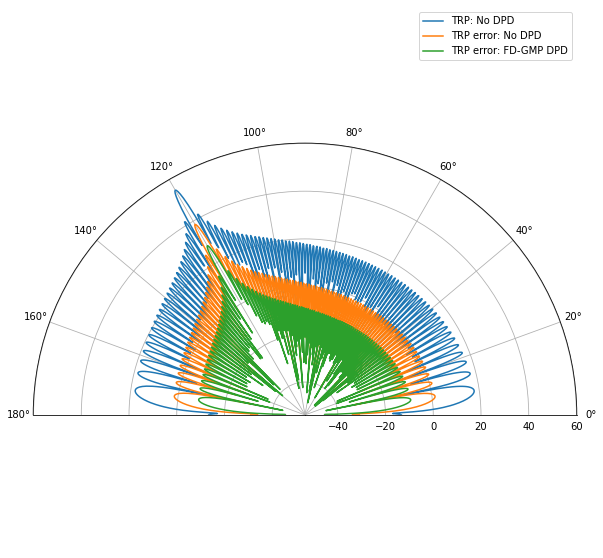

In [20]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(10, 10))
ax.set_thetamin(0)
ax.set_thetamax(180)

angles_plot = angles + np.pi/2
pow_align_for_plot= 40

ax.plot(angles_plot,TRP_NoDPD-pow_align_for_plot,label='TRP: No DPD')
ax.plot(angles_plot,TRP_error_NoDPD-pow_align_for_plot,label='TRP error: No DPD')
ax.plot(angles_plot,TRP_error_DPD-pow_align_for_plot,label='TRP error: FD-GMP DPD')
ax.legend()
ax.grid(True)

np.savez(os.path.join('Buffer_files','Pattern_FDCNN_B100U1.npz'),angles_plot\
         ,TRP_NoDPD,None, TRP_error_NoDPD, TRP_error_DPD)


# SISO No DPD

In [21]:
torch.manual_seed(0)
np.random.seed(0)

B = 1 # Basestation antanna size, 16
U = 1 # Number of users, 8

K_act = 16 # Active subcarries
K_CP = 0 #length of cyclic prefix (must be smaller than IDFT size but larger than L)
K_act_QPSK = 0 #int(K_act/2)
K_act_64QAM = K_act - K_act_QPSK
sub_spacing = 1.2e4
BW=K_act*sub_spacing

FD_OSR = 4 # Upsampling rate in frequency-domain
K_IDFT = int(K_act*FD_OSR)  # IDFT size & Total number of subcarries

sub_map_QPSK = list(range(K_IDFT-int(K_act_QPSK/2),K_IDFT)) + list(range(0,int(K_act_QPSK/2)))
sub_map_64QAM = list(range(K_IDFT-int(K_act_QPSK/2)-int(K_act_64QAM/2),K_IDFT-int(K_act_QPSK/2)))\
                + list(range(int(K_act_QPSK/2),int(K_act_QPSK/2)+int(K_act_64QAM/2)))
sub_map_data = sub_map_64QAM + sub_map_QPSK 
sub_map_guardband = list(set(range(K_IDFT))- set(sub_map_data))
sub_map_adjacent_right = list(range(K_act_64QAM//2,K_act_64QAM*3//2)) 
sub_map_adjacent_left = list(range(K_IDFT-K_act_64QAM*3//2,K_IDFT-K_act_64QAM//2))

Num_OFDMs = 100 
batch_size_2 = K_act_64QAM*U*Num_OFDMs
M_2 = 256

# PA hyperparameters
pa_model = 'gmp'
gmp = np.load('gmp.npz')
gmp_pa_K = [7,0,0] 
gmp_pa_M=[5,0,0] 
gmp_pa_N = [0,0]

# power gain of the PA from the RF WebLab setup from Chalmers: linear scale
weblab_gain = np.sqrt(10**(51.0/10))

# GMP DPD parameters
gmp_dpd_K=[5,0,0]
gmp_dpd_M=[5,0,0]
gmp_dpd_N=[0,0]

#SNR for training
# train_SNR = np.arange(26,27,100)
PAOutPowerdBm= np.arange(28,100,100) #48

num_batch = 100

#UE distances
c_light = 3e8
d_UE = 25*np.ones((U))
tau_UE = d_UE/c_light

channel_type = 'LOS'

if channel_type is 'Rayleigh':
    # channel taps
    L = 100
    fc=2e9
    #large-scale coefficient
    alpha=3.76
    sigma_sf=0
    noiseFigure=7
    constantTerm_meter= -35.3 # -35.3 dB at 1m corresponds to -148.1 dB at 1km using alpha=3.76
    #compute noise power
    noiseVardBm = -174 + 10*np.log10(BW) + noiseFigure 
elif channel_type is 'LOS':
    fc=3e10
    #large-scale coefficient
    alpha=2.1
    sigma_sf=0
    noiseFigure=7
    constantTerm_meter= -61.9 # -61.9 dB at 1m
    #compute noise power
    noiseVardBm = -174 + 10*np.log10(BW) + noiseFigure

gainOverNoisedB = constantTerm_meter - alpha*10*np.log10(d_UE) + sigma_sf*\
                                np.random.randn(d_UE.shape[0]) - noiseVardBm

UE_median_SNR = constantTerm_meter - alpha*10*np.log10(d_UE) - noiseVardBm + \
                    PAOutPowerdBm-10*np.log10(B*FD_OSR/U)

gainOverNoise_power = torch.tensor(10**(gainOverNoisedB/10),dtype=torch.complex64).to(device)
PAOutPower_power = torch.tensor(10**((PAOutPowerdBm-10)/10),dtype=torch.complex64).to(device)

sigma_channel = 1

# Time-domain channel parameters
channel_est_err=0 #.00015

Using_model_based_FD_DPD_Flag = False # True or False

# torch.manual_seed(0)
train_SNR_QPSK = np.array([])
ser_np_1= np.array([])
ser_np_2= np.array([])
ser_np_snr_1=np.array([])
ser_np_snr_2=np.array([])
loss_np=np.array([])

_pow_pa_out = torch.tensor([])
_pow_pa_out_with_dpd = torch.tensor([])
_pow_pa_out_mean = torch.tensor([])

lin_dpd_par = torch.zeros(K_act,dtype=torch.complex64)

evm_td_gmp = torch.tensor([])
evm_td_gmp_mean=torch.tensor([])

aclr_td_gmp = torch.tensor([])
aclr_td_gmp_mean=torch.tensor([])
aclr_td_gmp_noDPD_Tx=torch.tensor([])
aclr_td_gmp_DPD_Tx=torch.tensor([])
nmse_td_gmp_DPD_Tx = torch.tensor([])

#Iterate different PA output power set
for PAOutPower_power_current in PAOutPower_power:
    for batch_idx in range(num_batch):
        m_2, m_one_hot_2 = one_hot_generate(batch_size_2,M_2)
        x_symbs_2, const_2 = const_map(m_2,M_2)
        x_symbs_2_real = torch.view_as_real(x_symbs_2).to(device)
#         for K_IDFT_now = K_IDFT
        ################ S/P ###############
        x_symbs_parall = torch.zeros(U,Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)
        x_symbs_parall[:,:,sub_map_64QAM] = x_symbs_2.view(U,Num_OFDMs,K_act_64QAM).to(device)
        ############### 
        x_symbs_power_64QAM = torch.mean(torch.abs(x_symbs_parall[:,:,sub_map_64QAM])**2)
        ############## Time-domain channel matrix ##########
        if channel_type is 'Rayleigh':
            Ht = np.sqrt(0.5/L)*(torch.randn(U,B,L) + 1j*torch.randn(U,B,L)).to(device)
            Ht_est = np.sqrt(1-channel_est_err)*Ht + np.sqrt(channel_est_err/2)*(torch.randn(U,B,L) + 1j*torch.randn(U,B,L)).to(device)
            Ht_random = np.sqrt(0.5/L)*(torch.randn(U,B,L) + 1j*torch.randn(U,B,L)).to(device)

            Ht = torch.tensordot(torch.diag(gainOverNoise_power[:]),Ht,dims=([1],[0]))
            Ht_est = torch.tensordot(torch.diag(gainOverNoise_power[:]),Ht_est,dims=([1],[0]))
            Ht_random = torch.tensordot(torch.diag(gainOverNoise_power[:]),Ht_random,dims=([1],[0]))

            #########Frequency-domain channel matrix ######
            Hf = torch.fft.fft(Ht,K_IDFT,dim=2,norm='ortho')
            Hf_est = torch.fft.fft(Ht_est,K_IDFT,dim=2,norm='ortho')
            # Channel for a random spatial point
            Hf_random = torch.fft.fft(Ht_random,K_IDFT,dim=2)
        elif channel_type is 'LOS':
            Hf = torch.zeros(U,B,K_IDFT,dtype=torch.complex64).to(device)
            theta_UE = np.array([np.pi/6,-np.pi/4])
            
            Hf_random = torch.zeros(1,B,K_IDFT,dtype=torch.complex64).to(device)
            theta_random = np.random.uniform(-np.pi/2,np.pi/2,1)
            for b in range(B):
                for u in range(U):
#                     steer_vec = np.exp(-1j*2*np.pi*(fc + np.linspace(0,K_IDFT-1,K_IDFT)*sub_spacing)*(tau_UE[u] + b*np.sin(theta_UE[u])/2/fc))
                    steer_vec = np.exp(-1j*2*np.pi*(fc)*(tau_UE[u] + b*np.sin(theta_UE[u])/2/fc))

                    Hf[u,b,:] = gainOverNoise_power[u]*torch.tensor(steer_vec).to(device)
                Hf_random[0,b,:] = gainOverNoise_power[0]*torch.tensor(np.exp(1j*2*np.pi*\
                                            np.linspace(0,K_IDFT-1,K_IDFT)*sub_spacing*(tau_UE[0] + \
                                                                b*np.sin(theta_random)/fc/2))).to(device)
            Hf_est = Hf
            
        ############### Precoding ##############
        xf_all = torch.zeros(B,Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)
        xf_all[:,:,sub_map_data], Pf, beta_precod = zero_forcing(x_symbs_parall[:,:,sub_map_data],\
                                                     Hf_est[:,:,sub_map_data],B,U,K_act,Num_OFDMs)
        Pf_all, beta_precod_all = zero_forcing(x_symbs_parall,Hf_est,B,U,K_IDFT,Num_OFDMs,return_P_only_flag=True)

        
        ############## IDFT of OFDM: considering oversampling (zero-padding in FD --> OS in TD) ##############
        x_n = torch.fft.ifft(xf_all,K_IDFT,dim=2,norm='ortho')
        
        ############# Adding cyclic prefix ##########
        if K_CP>0:
            x_n = torch.cat((x_n[:,:,-K_CP:], x_n),2)

        ####### For each antenna ########
        x_n_PAs = torch.zeros(B,Num_OFDMs*(K_IDFT+K_CP),dtype=torch.complex64).to(device)
        x_n_PAs_NoDPD = torch.zeros(B,Num_OFDMs*(K_IDFT+K_CP),dtype=torch.complex64).to(device)
        x_n_idealPA  = torch.zeros(B,Num_OFDMs*(K_IDFT+K_CP),dtype=torch.complex64).to(device)
        dpd_out_OverSamp_collect=torch.zeros(B,Num_OFDMs*(K_IDFT+K_CP),dtype=torch.complex64).to(device)
        
        for b in range(B):
            ############### P/S ################
            x_n_serial = x_n[b,:,:].view(-1)
            
            #Compute drive gain for PAs with a fixed power for the array for any B and U
            driv_gain_2=torch.sqrt(PAOutPower_power_current*K_IDFT/K_act)
        
            sigma_channel_true = sigma_channel
            
            x_tx = x_n_serial*driv_gain_2
            x_tx_weblab = x_tx/weblab_gain

            ############# PA in time-domain ###########
            pa_out = PA(torch.view_as_real(x_tx_weblab),pa_model,K=gmp_pa_K,M=gmp_pa_M,b=0)
            pa_out_ideal = PA(torch.view_as_real(x_tx),'ideal',K=gmp_pa_K,M=gmp_pa_M)
            
            x_n_PAs_NoDPD[b,:] = torch.view_as_complex(pa_out)
            x_n_idealPA[b,:] = torch.view_as_complex(pa_out_ideal)
        
        x_n_PAs_no_PA = x_n*driv_gain_2
        x_n_test = x_n_PAs_NoDPD
            
        ############ Channel in Frequency-domain ##########
        x_n_test = x_n_test.view(B,Num_OFDMs,(K_IDFT+K_CP))
        x_n_NoDPD = x_n_PAs_NoDPD.view(B,Num_OFDMs,(K_IDFT+K_CP))
        x_n_no_PA = x_n_PAs_no_PA.view(B,Num_OFDMs,(K_IDFT+K_CP))
        
        xf_PAs_with_dpd = torch.fft.fft(x_n_test[:,:,K_CP:],K_IDFT,dim=2,norm='ortho')
        xf_PAs = torch.fft.fft(x_n_NoDPD[:,:,K_CP:],K_IDFT,dim=2,norm='ortho')
        xf_PAs_no_PA = torch.fft.fft(x_n_no_PA[:,:,K_CP:],K_IDFT,dim=2,norm='ortho')
         
        yf = torch.zeros(U,Num_OFDMs, K_IDFT,dtype=torch.complex64).to(device)
        yf_NoDPD = torch.zeros(U,Num_OFDMs, K_IDFT,dtype=torch.complex64).to(device)
        yf_NoDPD_random = torch.zeros(U,Num_OFDMs, K_IDFT,dtype=torch.complex64).to(device)
        yf_DPD_random = torch.zeros(U,Num_OFDMs, K_IDFT,dtype=torch.complex64).to(device)
        
        #Calculate the ACLR at the Tx
        aclr_td_gmp_noDPD_Tx = torch.hstack((aclr_td_gmp_noDPD_Tx ,10*torch.log10(torch.sum(torch.abs(xf_PAs[:,:,sub_map_64QAM].detach().to('cpu'))**2)/\
                        torch.maximum(torch.sum(torch.abs(xf_PAs[:,:,sub_map_adjacent_left].detach().to('cpu'))**2), \
                                      torch.sum(torch.abs(xf_PAs[:,:,sub_map_adjacent_right].detach().to('cpu'))**2)))))
        aclr_td_gmp_DPD_Tx = torch.hstack((aclr_td_gmp_DPD_Tx ,10*torch.log10(torch.sum(torch.abs(xf_PAs_with_dpd[:,:,sub_map_64QAM].detach().to('cpu'))**2)/\
                        torch.maximum(torch.sum(torch.abs(xf_PAs_with_dpd[:,:,sub_map_adjacent_left].detach().to('cpu'))**2), \
                                      torch.sum(torch.abs(xf_PAs_with_dpd[:,:,sub_map_adjacent_right].detach().to('cpu'))**2)))))
        #Calculate the NMSE at the Tx
        nmse_td_gmp_DPD_Tx = torch.hstack((nmse_td_gmp_DPD_Tx ,10*torch.log10(torch.mean(torch.abs(\
                                  x_n_PAs - driv_gain_2*x_n.view(B,-1))**2) \
                                    /torch.mean(torch.abs(driv_gain_2*x_n.view(B,-1))**2)).detach().to('cpu')))
        #Pass through the channel in frequency domain
        for k in range(0,K_IDFT):
            yf[:,:,k] = Hf[:,:,k]@xf_PAs_with_dpd[:,:,k]
            yf_NoDPD[:,:,k] = Hf[:,:,k]@xf_PAs[:,:,k]
        
            yf_NoDPD_random[:,:,k] = Hf_random[:,:,k]@xf_PAs[:,:,k]
            yf_DPD_random[:,:,k] = Hf_random[:,:,k]@xf_PAs_with_dpd[:,:,k]
        
        ############## AWGN ################
        y_symbs_FD = yf + sigma_channel_true * (torch.randn(yf.shape).to(device) + 1j*torch.randn(yf.shape).to(device))
        y_symbs_FD_NoDPD = yf_NoDPD + sigma_channel_true * (torch.randn(yf.shape).to(device) + 1j*torch.randn(yf.shape).to(device))

        ############# P/S #################
        y_symbs_serial_64QAM = y_symbs_FD[:,:,sub_map_64QAM].view(-1,1)
        y_symbs_serial_64QAM_amplitude = torch.sqrt(torch.mean(torch.abs(y_symbs_serial_64QAM)**2))
        y_symbs_serial_64QAM_norm = y_symbs_serial_64QAM/y_symbs_serial_64QAM_amplitude
        
        #QAM symbols at all subcarriers
        y_symbs_FD_allQAM = y_symbs_FD #sub_map_64QAM
        y_symbs_FD_allQAM_norm = y_symbs_FD_allQAM/y_symbs_serial_64QAM_amplitude
        
        y_symbs_FD_allQAM_NoDPD = y_symbs_FD_NoDPD #sub_map_64QAM
        y_symbs_FD_allQAM_NoDPD_amplitude = torch.sqrt(torch.mean(torch.abs(y_symbs_FD_allQAM_NoDPD[:,:,sub_map_64QAM])**2))
        y_symbs_FD_allQAM_norm_NoDPD = y_symbs_FD_allQAM_NoDPD/y_symbs_serial_64QAM_amplitude
        
        y_m_2 = const_demap(y_symbs_serial_64QAM_norm,const_2.to(device),M_2)
        ser_2 = SER(y_m_2,m_2,one_hot=False)
        ser_np_2 = np.append(ser_np_2,ser_2)
        _pow_pa_out = torch.hstack((_pow_pa_out,(10*torch.log10(torch.mean(torch.abs(x_n_PAs.detach().to('cpu'))**2)/100) + 30)))
        
        #Calculate the EVM
        evm_td_gmp = torch.hstack((evm_td_gmp, torch.sqrt(torch.mean(torch.abs(y_symbs_serial_64QAM_norm - x_symbs_parall[:,:,sub_map_64QAM].view(-1,1))**2)\
                                                         /torch.mean(torch.abs(x_symbs_parall[:,:,sub_map_64QAM].to('cpu')**2))).detach().to('cpu')))
        #Calculate the ACLR
        aclr_td_gmp = torch.hstack((aclr_td_gmp ,10*torch.log10(torch.sum(torch.abs(y_symbs_FD[:,:,sub_map_64QAM].detach().to('cpu'))**2)/\
                        torch.maximum(torch.sum(torch.abs(y_symbs_FD[:,:,sub_map_adjacent_left].detach().to('cpu'))**2), \
                                      torch.sum(torch.abs(y_symbs_FD[:,:,sub_map_adjacent_right].detach().to('cpu'))**2)))))
        
    ser_np_snr_2 = np.append(ser_np_snr_2,np.mean(ser_np_2[-num_batch:]))
    #train_SNR_QPSK = np.append(train_SNR_QPSK, i+20*np.log10(driv_gain_2.to('cpu').numpy()/driv_gain_1.to('cpu').numpy()))
    _pow_pa_out_mean =  torch.hstack((_pow_pa_out_mean, torch.mean(_pow_pa_out[-num_batch:])))
        #_pow_pa_out_with_dpd = torch.hstack((_pow_pa_out_with_dpd,avg_pow(pa_out_with_dpd.to('cpu'))))
    evm_td_gmp_mean = torch.hstack((evm_td_gmp_mean, torch.mean(evm_td_gmp[-num_batch:])))
    aclr_td_gmp_mean = torch.hstack((aclr_td_gmp_mean, torch.mean(aclr_td_gmp[-num_batch:])))

    print('SER =',"{:.2e}".format(ser_np_snr_2[-1]), ', EVM =',  "{:.2f}%".format(100*evm_td_gmp_mean[-1]), \
         ', OTA ACLR =',  "{:.2f}dBc".format(aclr_td_gmp_mean[-1]),', Tx ACLR =',\
          "{:.2f}dBc".format(aclr_td_gmp_DPD_Tx[-1]), ', PA Avg output power: ', "{:.2f}dBm".format(_pow_pa_out_mean[-1]))
    

SER = 5.21e-02 , EVM = 5.15% , OTA ACLR = 31.53dBc , Tx ACLR = 31.31dBc , PA Avg output power:  -infdBm


## Plot beampattern

In [22]:
yf_NoDPD_angle = torch.zeros(Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)
yf_DPD_angle = torch.zeros(Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)
yf_NoPA_angle = torch.zeros(Num_OFDMs,K_IDFT,dtype=torch.complex64).to(device)

num_angles =1000
angles = np.linspace(-np.pi/2,np.pi/2,num_angles)
Hf_angle = torch.zeros(num_angles,B,K_IDFT,dtype=torch.complex64).to(device)


TRP_error_NoDPD = torch.zeros(num_angles)
TRP_error_DPD = torch.zeros(num_angles)
TRP_NoDPD = torch.zeros(num_angles)
TRP_DPD = torch.zeros(num_angles)

for i in range(num_angles):
    for b in range(B):
        steer_vec = np.exp(-1j*2*np.pi*(fc+np.linspace(0,K_IDFT-1,K_IDFT)*sub_spacing)*(\
                                               b*np.sin(angles[i])/2/fc))
        Hf_angle[i,b,:] = torch.tensor(steer_vec).to(device)

    for k in range(0,K_IDFT):
        yf_NoDPD_angle[:,k] = Hf_angle[i,:,k]@xf_PAs[:,:,k]
        yf_DPD_angle[:,k] = Hf_angle[i,:,k]@xf_PAs_with_dpd[:,:,k]
        yf_NoPA_angle[:,k] = Hf_angle[i,:,k]@xf_PAs_no_PA[:,:,k]

    yf_NoDPD_symbs_angle = yf_NoDPD_angle + 0.001*(sigma_channel_true * (torch.randn(yf_NoDPD_angle.shape).to(device) + 1j*torch.randn(yf_NoDPD_angle.shape).to(device)))
    yf_DPD_symbs_angle = yf_DPD_angle + 0.001*(sigma_channel_true * (torch.randn(yf_DPD_angle.shape).to(device) + 1j*torch.randn(yf_DPD_angle.shape).to(device)))
    
    TRP_error_NoDPD[i] = 10*torch.log10(torch.sum(abs(yf_NoDPD_symbs_angle[:,:]-yf_NoPA_angle[:,:]).detach().to('cpu')**2))
    TRP_error_DPD[i] = 10*torch.log10(torch.sum(abs(yf_DPD_symbs_angle[:,:]-yf_NoPA_angle[:,:]).detach().to('cpu')**2))
    TRP_NoDPD[i] = 10*torch.log10(torch.sum(abs(yf_NoDPD_symbs_angle[:,:]).detach().to('cpu')**2))
    TRP_DPD[i] = 10*torch.log10(torch.sum(abs(yf_DPD_symbs_angle[:,:]).detach().to('cpu')**2))


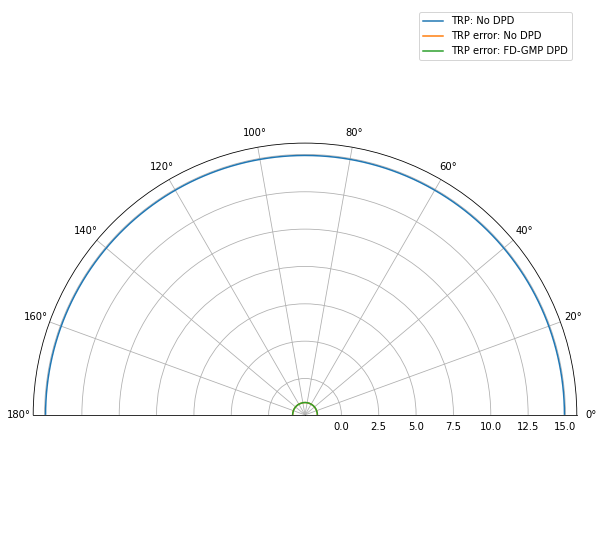

In [23]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(10, 10))
ax.set_thetamin(0)
ax.set_thetamax(180)

angles_plot = angles + np.pi/2
pow_align_for_plot= 40

ax.plot(angles_plot,TRP_NoDPD-pow_align_for_plot,label='TRP: No DPD')
ax.plot(angles_plot,TRP_error_NoDPD-pow_align_for_plot,label='TRP error: No DPD')
ax.plot(angles_plot,TRP_error_DPD-pow_align_for_plot,label='TRP error: FD-GMP DPD')

ax.legend()

ax.grid(True)

np.savez(os.path.join('Buffer_files','Pattern_SISO_B1U1'),angles_plot\
         ,TRP_NoDPD,None, TRP_error_NoDPD, TRP_error_DPD)


# Plot beampattern results of all schemes

After the collection of all DPD shcemes results, plot them together.

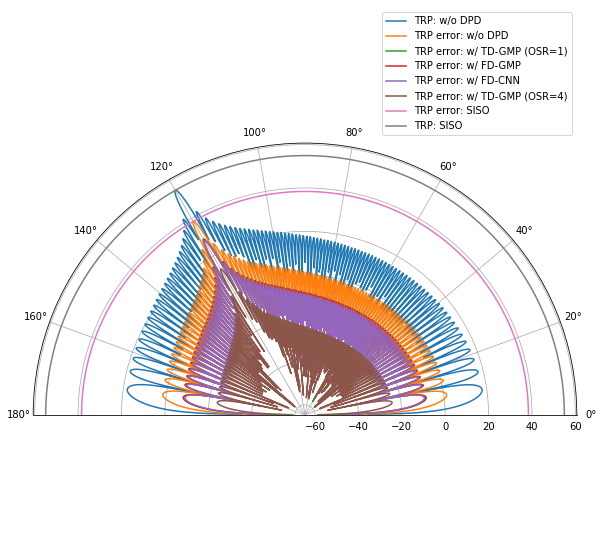

In [24]:
avg_for_plot=1

FD_pattern_TDGMP_OSR4 = np.load(os.path.join('Buffer_files','Pattern_TDGMP_OSR4_B100U1.npz'))
TDGMP_OSR4_angles =  FD_pattern_TDGMP_OSR4["arr_0"]
TDGMP_OSR4_TRP_NoDPD =  FD_pattern_TDGMP_OSR4["arr_1"]
TDGMP_OSR4_oob_powers_NoDPD = FD_pattern_TDGMP_OSR4["arr_3"]
TDGMP_OSR4_oob_powers_DPD = FD_pattern_TDGMP_OSR4["arr_4"]
TDGMP_TRP_ACLR = 10*np.log10(np.sum(10**(TDGMP_OSR4_TRP_NoDPD/10))/np.sum(10**(TDGMP_OSR4_oob_powers_DPD/10)))
TDGMP_TRP_ACLR_NoDPD = 10*np.log10(np.sum(10**(TDGMP_OSR4_TRP_NoDPD/10))/np.sum(10**(TDGMP_OSR4_oob_powers_NoDPD/10)))

FD_pattern_TDGMP_SISO = np.load(os.path.join('Buffer_files','Pattern_SISO_B1U1.npz'))
TDGMP_SISO_angles =  FD_pattern_TDGMP_SISO["arr_0"]
TDGMP_SISO_TRP_NoDPD =  FD_pattern_TDGMP_SISO["arr_1"]
TDGMP_SISO_oob_powers_NoDPD = FD_pattern_TDGMP_SISO["arr_3"]
TDGMP_SISO_oob_powers_DPD = FD_pattern_TDGMP_SISO["arr_4"]
TDGMP_SISO_TRP_ACLR = 10*np.log10(np.sum(10**(TDGMP_SISO_TRP_NoDPD/10))/np.sum(10**(TDGMP_SISO_oob_powers_DPD/10)))

FD_pattern_TDGMP_OSR1 = np.load(os.path.join('Buffer_files','Pattern_TDGMP_OSR1_B100U1.npz'))
TDGMP_OSR1_angles =  FD_pattern_TDGMP_OSR1["arr_0"]
TDGMP_OSR1_TRP_NoDPD =  FD_pattern_TDGMP_OSR1["arr_1"]
TDGMP_OSR1_oob_powers_NoDPD = FD_pattern_TDGMP_OSR1["arr_3"]
TDGMP_OSR1_oob_powers_DPD = FD_pattern_TDGMP_OSR1["arr_4"]
TDGMP_OSR1_TRP_ACLR = 10*np.log10(np.sum(10**(TDGMP_OSR1_TRP_NoDPD/10))/np.sum(10**(TDGMP_OSR1_oob_powers_DPD/10)))

FD_pattern_FDGMP_OSR4 = np.load(os.path.join('Buffer_files','Pattern_FDGMP_OSR4_B100U1.npz'))
FDGMP_OSR4_angles =  FD_pattern_FDGMP_OSR4["arr_0"]
FDGMP_OSR4_TRP_NoDPD =  FD_pattern_FDGMP_OSR4["arr_1"]
FDGMP_OSR4_oob_powers_NoDPD = FD_pattern_FDGMP_OSR4["arr_3"]
FDGMP_OSR4_oob_powers_DPD = FD_pattern_FDGMP_OSR4["arr_4"]
FDGMP_OSR4_TRP_ACLR = 10*np.log10(np.sum(10**(FDGMP_OSR4_TRP_NoDPD/10))/np.sum(10**(FDGMP_OSR4_oob_powers_DPD/10)))

# FD_pattern_FDNN = np.load(os.path.join('Buffer_files','Pattern_FD_NN_B100U1.npz'))
# FDNN_angles =  FD_pattern_FDNN["arr_0"]
# FDNN_TRP_NoDPD =  FD_pattern_FDNN["arr_1"]
# FDNN_TRP_distortion_NoDPD =  FD_pattern_FDNN["arr_2"]
# FDNN_oob_powers_NoDPD = FD_pattern_FDNN["arr_3"]
# FDNN_oob_powers_DPD = FD_pattern_FDNN["arr_4"]
# FDNN_TRP_ACLR = 10*np.log10(np.sum(10**(FDNN_TRP_NoDPD/10))/np.sum(10**(FDNN_oob_powers_DPD/10)))

FD_pattern_FDCNN = np.load(os.path.join('Buffer_files','Pattern_FDCNN_B100U1.npz'))
FDCNN_angles =  FD_pattern_FDCNN["arr_0"]
FDCNN_TRP_NoDPD =  FD_pattern_FDCNN["arr_1"]
FDCNN_oob_powers_NoDPD = FD_pattern_FDCNN["arr_3"]
FDCNN_oob_powers_DPD = FD_pattern_FDCNN["arr_4"]
FDCNN_TRP_ACLR = 10*np.log10(np.sum(10**(FDCNN_TRP_NoDPD/10))/np.sum(10**(FDCNN_oob_powers_DPD/10)))

pow_align_for_plot=40

degree_flag=False
if degree_flag:
    deg_convert = 180/np.pi
    fig, ax = plt.subplots(figsize=(10, 10))
else: 
    deg_convert= 1
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(10, 10))
    ax.set_thetamin(0)
    ax.set_thetamax(180)

ax.plot(TDGMP_OSR4_angles[::avg_for_plot]*deg_convert,np.mean(TDGMP_OSR4_TRP_NoDPD.reshape\
                      (-1,avg_for_plot),axis=1)-pow_align_for_plot,label='TRP: w/o DPD')
ax.plot(TDGMP_OSR4_angles[::avg_for_plot]*deg_convert,np.mean(TDGMP_OSR4_oob_powers_NoDPD.reshape\
                      (-1,avg_for_plot),axis=1)-pow_align_for_plot,label='TRP error: w/o DPD')
ax.plot(TDGMP_OSR1_angles[::avg_for_plot]*deg_convert,np.mean(TDGMP_OSR1_oob_powers_DPD.reshape\
       (-1,avg_for_plot),axis=1)-pow_align_for_plot,label='TRP error: w/ TD-GMP (OSR=1)')
ax.plot(FDGMP_OSR4_angles*deg_convert,FDGMP_OSR4_oob_powers_DPD-pow_align_for_plot,\
        label='TRP error: w/ FD-GMP')
# ax.plot(FDNN_angles*deg_convert,FDNN_oob_powers_DPD-pow_align_for_plot,\
#         label='OOB w/ FD-NN')
ax.plot(FDCNN_angles*deg_convert,FDCNN_oob_powers_DPD-pow_align_for_plot,\
        label='TRP error: w/ FD-CNN')
ax.plot(TDGMP_OSR4_angles[::avg_for_plot]*deg_convert,np.mean(TDGMP_OSR4_oob_powers_DPD.reshape\
       (-1,avg_for_plot),axis=1)-pow_align_for_plot,label='TRP error: w/ TD-GMP (OSR=4)')

ax.plot(TDGMP_SISO_angles*deg_convert,TDGMP_SISO_oob_powers_DPD-pow_align_for_plot+40-0,\
        label='TRP error: SISO')
ax.plot(TDGMP_SISO_angles*deg_convert,TDGMP_SISO_TRP_NoDPD-pow_align_for_plot+40-0,\
        label='TRP: SISO')

ax.legend()

ax.grid(True)
